In [1]:
import sys,os


In [2]:
import AtmosphericBlocking
import numpy as np
import h5py
import glob
import matplotlib.pyplot as plt
%matplotlib inline

/home/adiv/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The equation our model solves is $$\frac{\partial}{\partial t}\hat{A}(x,t) = - \frac{\partial}{\partial x}\left[\left(C(x)-\alpha\hat{A}\right)\hat{A}\right]+\hat{S}-\frac{\hat{A}}{\tau}+D\frac{\partial^2\hat{A}}{\partial x^2}$$

There are two directions in which we can explore this: forcing and background conditions (set by $C(x)$).

The background $C(x)$ is defined as $$C(x) = u_\text{ref} + c_g - 2\alpha A_0(x)$$
where $$A_0(x) = Y\left[1-\cos\left(\frac{2\pi nx}{L_x}\right)\right]$$ where $Y$ is the amplitude and $n$ is the wavenumber of the background stationary wave $A_0$.

The total LWA is $$A = A_0+\hat{A}.$$

Zonal LWA flux is defined as $$F(x,t) = \left(C(x)-\alpha\hat{A}(x,t)\right)\hat{A}(x,t)$$
while eastward wind $u(x,t)$ is defined as $$u(x,t) = 40-\alpha A.$$

So if we want to vary $C(x)$, there are three things we can play with:
  * $\beta = u_\text{ref} + c_g$
  * $Y$
  * $n$

In [3]:
def gaussforce(x,t,peak=2,inject=True,tw=2.5,xw=2800.0e3,xc=16800.0e3,tc=277.8):
  # Gaussian centered at 277.8 days and 16,800 km
    tc = tc
    tw = tw
    t = t/86400.0
    xc = xc
    xw = xw
    sx = 1.852e-5 + np.zeros(len(x))
    if inject:
        sx *= (1+peak*np.exp(-((x-xc)/xw)**2 - ((t-tc)/tw)**2))
    return sx

In [4]:
def force_all(x,t,peak=2,inject=True,tw=2.5,xw=2800.0e3,xc=16800.0e3,tc=277.8):
  # Gaussian centered at 277.8 days
    tc = tc
    tw = tw
    t = t/86400.0
    xc = xc
    xw = xw
    sx = 1.852e-5 + np.zeros(len(x))
    if inject:
        sx *= (1+peak*np.exp(- ((t-tc)/tw)**2))
    return sx

In [5]:
def noboru_cx(x,Lx,alpha):
  # The background conditions used in Noboru's paper
    A0 = 10*(1-np.cos(4*np.pi*x/Lx))
    cx = 60 - 2*alpha*A0
    return cx,A0

In [6]:
def noiseforce(x,t,peak=2,inject=True,freqs=np.arange(10),speeds=np.arange(10),phases=np.zeros(10),ampls=np.ones(10),Lx=28000.0e3,
              tw=2.5,xw=2800.0e3,xc=16800.0e3,tc=277.8):
    if t/86400<270:
        return np.zeros(x.shape)+1.852e-5
    sx = np.zeros(x.shape)
    wampls = ampls*peak
    for i in range(0,len(freqs)):
        sx += 1.0/len(freqs)*wampls[i]*np.sin(2*np.pi*freqs[i]*x/Lx+speeds[i]*t+phases[i])
    sx = 1.852e-5*np.maximum(1,(1 + sx**3))
    return sx

In [7]:
class conditions:
    def __init__(self,peak=2,inject=True,Y=10,beta=60,n=2,alpha=0.55,tau=10.0,sfunc=None,
                 xc=16800.0e3,xw=2800.0e3,tw=2.5,tc=277.8,noisy=False):
        self.peak = peak
        self.inject=inject
        self.Y = Y
        self.sfunc=sfunc
        self.tw = tw
        self.tc = tc
        self.xc = xc
        self.xw = xw
        self.noisy=noisy
        if not sfunc:
            self.sfunc=gaussforce
        self.tau = tau*86400.0
        self.beta = beta
        self.n=n
        self.alpha = alpha
    def forcing(self,x,t,peak=None,inject=None):
        if peak:
            self.peak = peak
        if inject:
            self.inject = inject
        sx = self.sfunc(x,t,peak=self.peak,inject=self.inject,tw=self.tw,xc=self.xc,
                        xw=self.xw,tc=self.tc)
        return sx
    def getcx(self,x,Lx,alpha=None,time=None):
        if alpha:
            self.alpha = alpha
        A0 = self.Y*(1-np.cos(2*self.n*np.pi*x/Lx))
        cx = self.beta - 2*self.alpha*A0
        return cx,A0

In [8]:
class noisyconditions:
    def __init__(self,peak=2,Y=10,beta=60,n=2,background=True,forcing=True,nwforce=26,nwcx=21,maxforcex=20,maxA0x=10,forcedecay=20,A0decay=40,alpha=0.55,
                 tc=277.8,tw=2.5,xc=16800.0e3,xw=2800.0e3,sfunc=None,cfunc=None,inject=True,cxpeak=0.5,tau=10.0):
        self.peak = peak
        self.cxpeak = cxpeak
        self.inject=inject
        self.Y = Y
        self.sfunc=sfunc
        self.tw = tw
        self.tc = tc
        self.xc = xc
        self.xw = xw
        self.background=background
        self.forcingbool=forcing
        self.cfunc=cfunc
        self.tau = tau*86400.0
        if not sfunc and not forcing:
            print(forcing,sfunc)
            self.sfunc=gaussforce
        elif not sfunc and forcing:
            self.sfunc = noiseforce
        self.beta = beta
        self.n=n
        self.alpha = alpha
        if forcing:
            self.ffreqs = np.random.randint(1,maxforcex,size=nwforce)
            self.fspeeds = 2.0*np.pi/(forcedecay*86400.0) - 4*np.pi/(forcedecay*86400.0)*np.random.rand(nwforce)  
            self.fphases = np.random.rand(nwforce)*2*np.pi
            self.fampls = 3.7*np.random.rand(nwforce) #6.8
        if background:
            self.cfreqs = np.random.randint(1,maxA0x,size=nwcx)
            self.cspeeds = 2.0*np.pi/(A0decay*86400.0) - 4*np.pi/(A0decay*86400.0)*np.random.rand(nwcx)  
            self.cphases = np.random.rand(nwcx)*2*np.pi
            self.campls = np.random.rand(nwcx)
        
        
    def forcing(self,x,t,peak=None,inject=None):
        if peak:
            self.peak = peak
        if inject:
            self.inject = inject
        if not self.forcingbool:
            sx = self.sfunc(x,t,peak=self.peak,inject=self.inject,tw=self.tw,xc=self.xc,
                            xw=self.xw,tc=self.tc)
        else:
            sx = self.sfunc(x,t,peak=self.peak,freqs=self.ffreqs,speeds=self.fspeeds,phases=self.fphases,ampls=self.fampls)
        return sx
    def getcx(self,x,Lx,alpha=None,time=None):
        if alpha:
            self.alpha = alpha
        A0 = self.Y*(1-np.cos(2*self.n*np.pi*x/Lx))
        if self.background:
            A0 *= self.cfunc(x,Lx,t=time,freqs=self.cfreqs,speeds=self.cspeeds,phases=self.cphases,ampls=self.cxpeak*self.campls)
        cx = self.beta - 2*self.alpha*A0
        
        return cx,A0

In [9]:
def noisybackground(x,Lx,t=None,freqs=None,speeds=None,phases=None,ampls=None):
    dcx = np.zeros(len(x))
    for i in range(0,len(freqs)):
        dcx += 1.0/len(freqs)*ampls[i]*np.sin(2*np.pi*freqs[i]*x/Lx+speeds[i]*t+phases[i])
    return (1+dcx)

In [10]:
def count_blocks(mask,dx,dt):
    dsh = mask.shape
    nt = dsh[0]
    nx = dsh[1]
    dmask = np.zeros(np.array(mask.shape)+[2*dt,2*dx])
    dmask[dt:-dt,dx:-dx] = mask[:,:]
    dmask[dt:-dt,0:dx] = mask[:,-dx:]
    dmask[dt:-dt,-dx:] = mask[:,0:dx]
    
    ict = 0
    for it in range(nt+dt,dt,-1):
        for ix in range(dx,nx+dx):
            if dmask[it,ix]==1:
                if np.sum(dmask[it-dt:it+dt,ix-dx:ix+dx])>1:
                    dmask[it,ix]=0
    
    ict = np.sum(dmask[dt:-dt,dx:-dx])
    return ict,dmask[dt:-dt,dx:-dx]

In [56]:
noisy_initc = noisyconditions(nwcx=21,maxA0x=10,A0decay=40,cfunc=noisybackground,background=True,forcing=True,n=2,Y=0.2,beta=25)

### Note: Following cell deletes output folder. May want to turn off.

In [57]:
cleanup = True
if cleanup:
    os.system("rm -rf output/")

In [58]:
cond = noisy_initc

In [59]:
model = AtmosphericBlocking.Model(nx=1024,Lx = 28000e3,dt=.005*86400,alpha=cond.alpha,
                                        tmax=3.5*86400,D=3.26e5,tau=cond.tau,
                                        sfunc=cond.forcing,cfunc=cond.getcx,
                                        forcingpeak=cond.peak,injection=cond.inject,
                                        save_to_disk=True,
                                        overwrite=True,
                                        tsave_snapshots=50,
                                        path = 'output/')

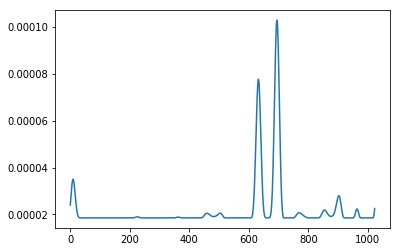

In [60]:
plt.plot(model.sfunc(model.x,280.0*86400.0))

In [61]:
model.tmax = 450*86400
model.run()

In [62]:

setup = h5py.File("output/setup.h5")
x = setup['grid/x'][:]

In [63]:
fnis = np.array(sorted(glob.glob("output/snapshots/*.h5")))

In [64]:
Ahat, F, S, C = 0,0,0,0
t = []
for fni in fnis[0::2]:
    snap = h5py.File(fni)
    t.append(snap['t'][()])
    try:
        Ahat = np.vstack([Ahat, snap['A'][:]])
        F = np.vstack([F, snap['F'][:]])
        S = np.vstack([S, snap['S'][:]])
        C = np.vstack([C, snap['C'][:]])
    except:
        Ahat = snap['A'][:]
        F = snap['F'][:]
        S = snap['S'][:]
        C = snap['C'][:]

t = np.array(t)

In [65]:
fnis.shape

(1800,)

In [66]:
t.shape

(900,)

In [67]:
print(Ahat.shape,model.A0.shape,F.shape)

(900, 1024) (1024,) (900, 1024)


In [68]:
print(np.where(t/86400 > 260)[0][0])
it0 = np.where(t/86400 > 260)[0][0]

520


Text(0.5,1,'S')

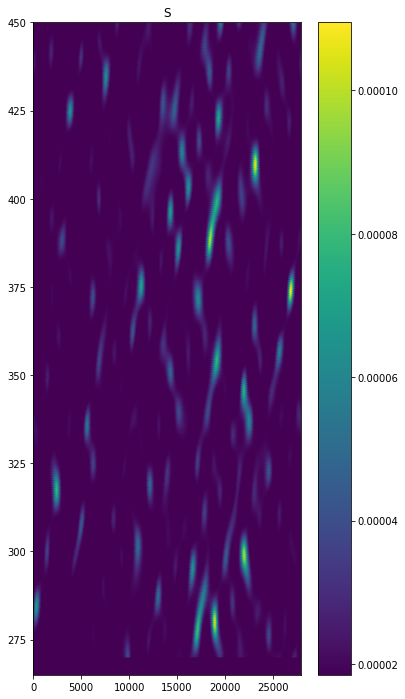

In [69]:
fig,ax=plt.subplots(figsize=(6.,12.))
plt.pcolormesh(x/1e3,t[it0:]/86400,(S[it0:]),shading='Gouraud',cmap='viridis')
plt.ylim(265,450)
plt.colorbar()
plt.title("S")
#plt.savefig("s_field.pdf",bbox_inches='tight')

21.0


Text(0.5,1,'S Mask')

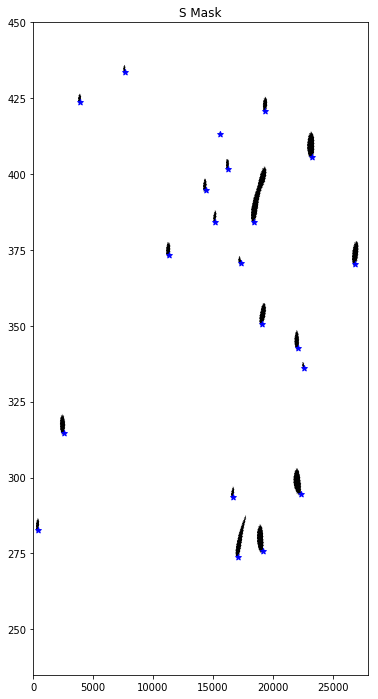

In [70]:
smask = (S[it0-100:]>0.6e-4)*1.0

sct,scmask = count_blocks(smask,5,5)
print(sct)
sts = t[it0-100:][np.where(scmask>0.5)[0]]/86400
sxs = x[np.where(scmask>0.5)[1]]/1e3
fig,ax=plt.subplots(figsize=(6.,12.))
plt.pcolormesh(x/1e3,t[it0-100:]/86400,smask,shading='Gouraud',cmap='Greys')
plt.scatter(sxs,sts,marker='*',color='b')
plt.ylim(235,450)
plt.title("S Mask")

Text(0.5,0,'Distance [km]')

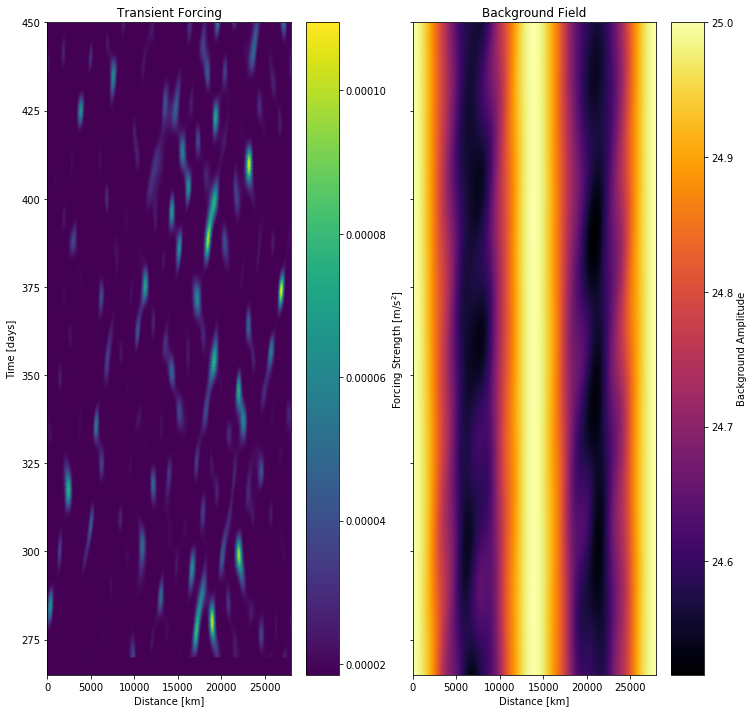

In [71]:
fig,axes=plt.subplots(1,2,figsize=(12.,12.),sharey=True)
im1=axes[0].pcolormesh(x/1e3,t[it0:]/86400,(S[it0:]),shading='Gouraud',cmap='viridis')
axes[0].set_ylim(265,450)
plt.colorbar(im1,label="Forcing Strength [m/s$^2$]",ax=axes[0])
axes[0].set_title("Transient Forcing")
im2=axes[1].pcolormesh(x/1e3,t[it0:]/86400,(C[it0:]),shading='Gouraud',cmap='inferno')
#plt.ylim(270,300)
#plt.xlim(7000,12000)
plt.colorbar(im2,label="Background Amplitude",ax=axes[1])
axes[1].set_title("Background Field")
axes[0].set_ylabel("Time [days]")
axes[0].set_xlabel("Distance [km]")
axes[1].set_xlabel("Distance [km]")
#plt.savefig("cx_s_field.png",bbox_inches='tight')

Text(0.5,1,'F')

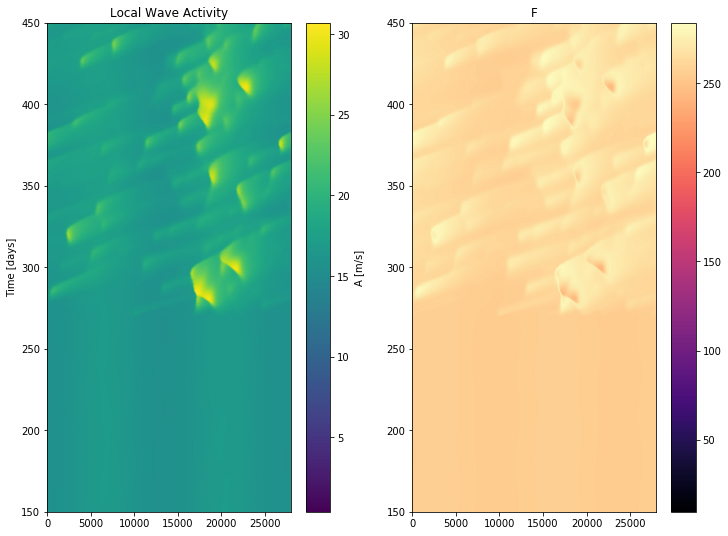

In [72]:
plt.figure(figsize=(12.,9))
plt.subplot(121)
plt.pcolormesh(x/1e3,t[:]/86400,(Ahat+model.A0[np.newaxis,:])[:],shading='Gouraud',cmap='viridis')
plt.ylim(150,450)
plt.ylabel("Time [days]")
plt.colorbar(label="A [m/s]")
plt.title("Local Wave Activity")

plt.subplot(122)
plt.pcolormesh(x/1e3,t[:]/86400,F[:],shading='Gouraud',cmap='magma')
plt.ylim(150,450)
plt.colorbar()
plt.title("F")
#plt.savefig("lwa_flux_random-cx-s.pdf",bbox_inches='tight')

In [73]:
import matplotlib.colors as colors

In [74]:
print(1)

1


Text(0.5,1,'$-\\partial_xF$')

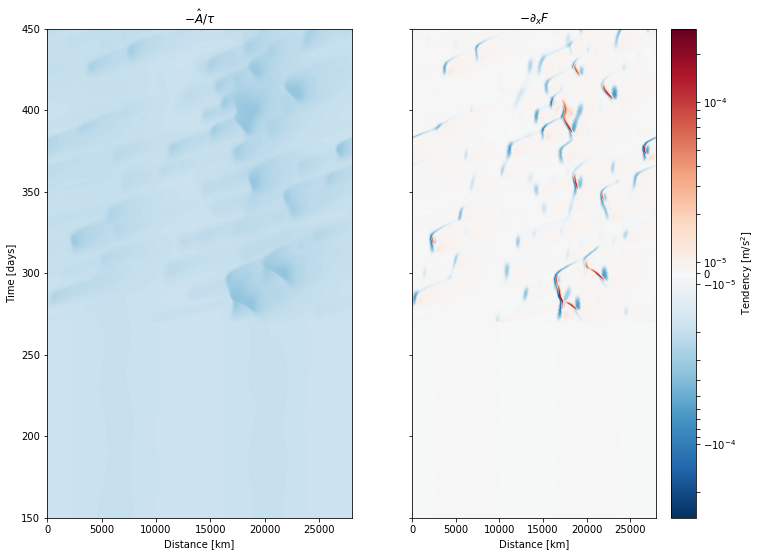

In [75]:

fterm = -np.gradient(F[:],x[1]-x[0],axis=1)
Dterm = 3.26e5*np.gradient(np.gradient(Ahat,x[1]-x[0],axis=1),x[1]-x[0],axis=1)
ahtau = -Ahat/(10.0*86400.0)
fmin = -np.amax(abs(fterm))
fmax = np.amax(abs(fterm))
ahmin = -np.amax(abs(ahtau))
ahmax = np.amax(abs(ahtau))
dmin = -np.amax(abs(Dterm))
dmax = np.amax(abs(Dterm))
smin = -np.amax(abs(S))
smax = np.amax(abs(S))
vmin = np.amin([fmin,ahmin,dmin,smin])
vmax = np.amax([fmax,ahmax,dmax,smax])

fig,axes=plt.subplots(1,2,figsize=(12.,9),sharey=True)
axes[0].pcolormesh(x/1e3,t[:]/86400,-(Ahat)/(10.0*86400.0),shading='Gouraud',cmap='RdBu_r',norm=colors.SymLogNorm(linthresh=1.0e-5, linscale=0.1,vmin=vmin,vmax=vmax))
axes[0].set_ylim(150,450)
axes[0].set_title("$-\hat{A}/\\tau$")
axes[0].set_ylabel("Time [days]")

im=axes[1].pcolormesh(x/1e3,t[:]/86400,fterm,shading='Gouraud',cmap='RdBu_r',norm=colors.SymLogNorm(linthresh=1.0e-5, linscale=0.1,vmin=vmin,vmax=vmax))
axes[1].set_ylim(150,450)
axes[1].set_xlabel("Distance [km]")
axes[0].set_xlabel("Distance [km]")
plt.colorbar(im,label="Tendency [m/s$^2$]",ax=axes[1])
axes[1].set_title("$-\partial_xF$")
#plt.savefig("eqn_components1.png",bbox_inches='tight')

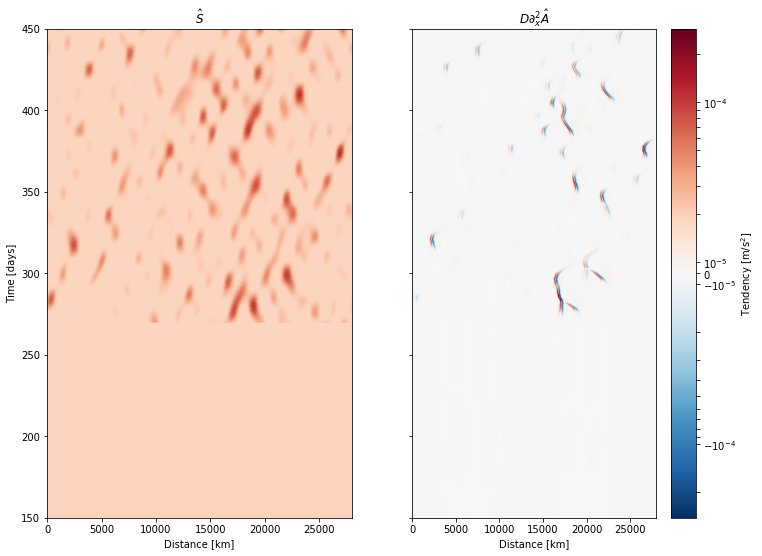

In [76]:
fig,axes = plt.subplots(1,2,figsize=(12.,9),sharey=True)
im=axes[0].pcolormesh(x/1e3,t[:]/86400,S,shading='Gouraud',cmap='RdBu_r',norm=colors.SymLogNorm(linthresh=1.0e-5, linscale=0.1,vmin=vmin,vmax=vmax))
axes[0].set_ylim(150,450)
axes[0].set_ylabel("Time [days]")
axes[0].set_title("$\hat{S}$")
axes[0].set_xlabel("Distance [km]")
axes[1].set_xlabel("Distance [km]")
axes[1].pcolormesh(x/1e3,t[:]/86400,Dterm,shading='Gouraud',cmap='RdBu_r',norm=colors.SymLogNorm(linthresh=1.0e-5, linscale=0.1,vmin=vmin,vmax=vmax))
axes[1].set_title("$D\partial_x^2\hat{A}$")
plt.colorbar(im,label="Tendency [m/s$^2$]",ax=axes[1])
#plt.savefig("eqn_components2.png",bbox_inches='tight')

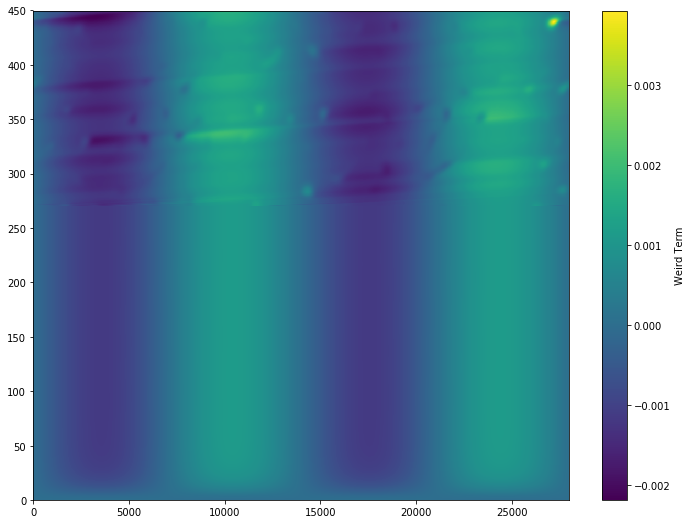

In [32]:
plt.figure(figsize=(12.,9))
im=plt.pcolormesh(x/1e3,t/86400,10*Ahat*np.gradient(np.cos(4*np.pi*model.x[np.newaxis]/28000.0e3)*Ahat,x[1]-x[0],axis=1))
plt.colorbar(im,label="Weird Term")

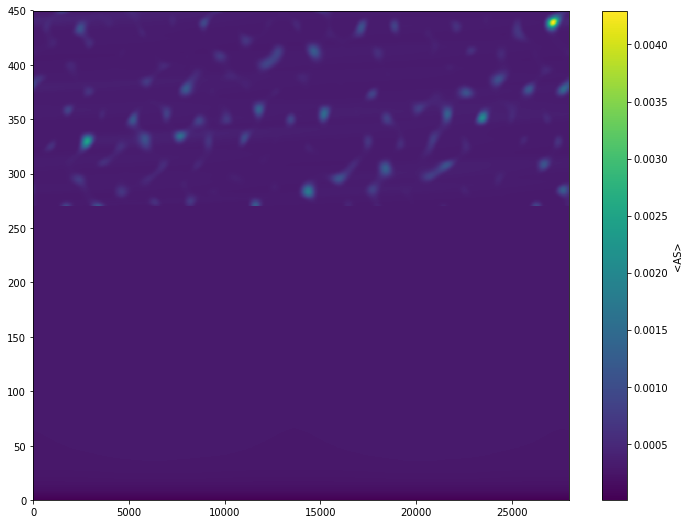

In [33]:
plt.figure(figsize=(12.,9))
im=plt.pcolormesh(x/1e3,t/86400,Ahat*S)
plt.colorbar(im,label="<AS>")

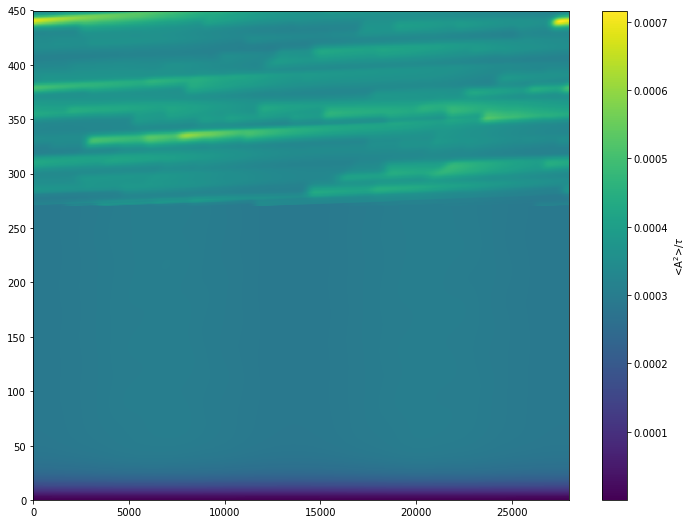

In [34]:
plt.figure(figsize=(12.,9))
im=plt.pcolormesh(x/1e3,t/86400,Ahat**2/(10.0*86400.0))
plt.colorbar(im,label="<A$^2$>/$\\tau$")

In [35]:
ua = 40-cond.alpha*(Ahat+model.A0[np.newaxis,:])

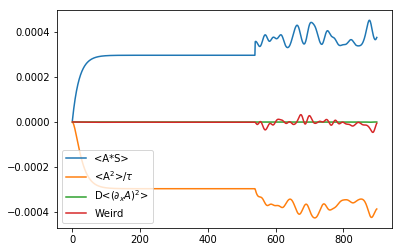

In [36]:
plt.plot(np.mean(Ahat*S,axis=1),label="<A*S>")
plt.plot(-np.mean(Ahat**2,axis=1)/(10.0*86400.0),label="<A$^2$>/$\\tau$")
plt.plot(-3.26e5*np.mean(np.gradient(Ahat,x[1]-x[0],axis=1)**2,axis=1),label="D<$(\partial_xA)^2$>")
plt.plot(np.mean(10*Ahat*np.gradient(np.cos(4*np.pi*model.x[np.newaxis]/28000.0e3)*Ahat,x[1]-x[0],axis=1),axis=1),label='Weird')
plt.legend(loc='best')
#plt.yscale('log')

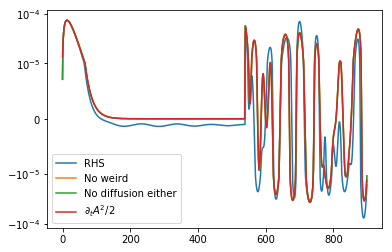

In [37]:
term1 = np.mean(Ahat*S,axis=1) \
      +np.mean(10*Ahat*np.gradient(np.cos(4*np.pi*model.x[np.newaxis]/28000.0e3)*Ahat,x[1]-x[0],axis=1),axis=1) \
      -np.mean(Ahat**2,axis=1)/(10.0*86400.0) \
      -3.26e5*np.mean(np.gradient(Ahat,x[1]-x[0],axis=1)**2,axis=1)
term2 = np.mean(Ahat*S,axis=1) \
      -np.mean(Ahat**2,axis=1)/(10.0*86400.0) \
      -3.26e5*np.mean(np.gradient(Ahat,x[1]-x[0],axis=1)**2,axis=1)
term3 = np.mean(Ahat*S,axis=1) \
      -np.mean(Ahat**2,axis=1)/(10.0*86400.0)
plt.plot(term1,label="RHS")
plt.plot(term2,label="No weird")
plt.plot(term3,label="No diffusion either")
plt.plot(np.gradient(np.mean(Ahat**2,axis=1),t[1]-t[0],axis=0)/2.0,label="$\partial_t A^2/2$")
plt.yscale('symlog',linthreshy=1.0e-5)
plt.legend(loc='best')

Text(0.5,1,'Eastward Wind')

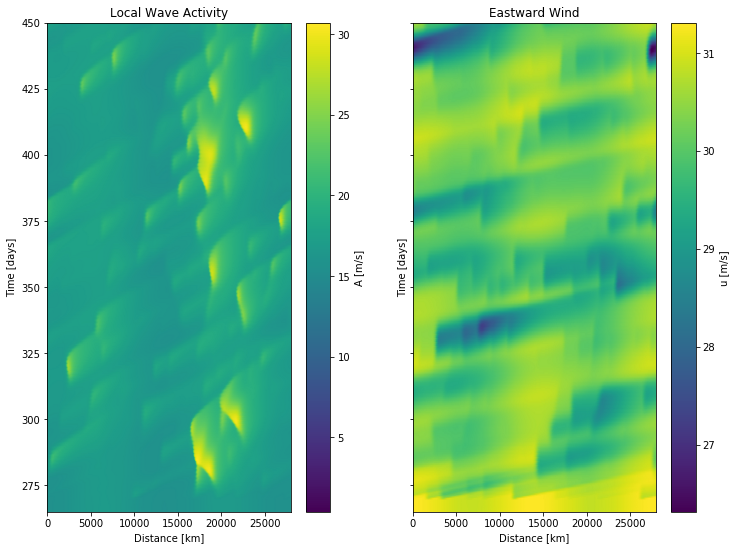

In [77]:
fig,axes=plt.subplots(1,2,figsize=(12.,9),sharey=True)
im=axes[0].pcolormesh(x/1e3,t[:]/86400,(Ahat+model.A0[np.newaxis,:])[:],shading='Gouraud',cmap='viridis')
axes[0].set_ylim(150,450)
axes[0].set_ylabel("Time [days]")
plt.colorbar(im,label="A [m/s]",ax=axes[0])
axes[0].set_title("Local Wave Activity")
axes[0].set_xlabel("Distance [km]")

im=axes[1].pcolormesh(x/1e3,t[it0:]/86400,(ua)[it0:],shading='Gouraud',cmap='viridis')
plt.colorbar(im,label="u [m/s]",ax=axes[1])
axes[1].set_ylim(265,450)
axes[1].set_ylabel("Time [days]")
axes[1].set_xlabel("Distance [km]")
axes[1].set_title("Eastward Wind")
#plt.savefig("lwa_wind.png",bbox_inches='tight')

In [39]:
def trajectory_ua(t0,xx,times,ua,L):
    traj = []
    ttimes = []
    posx = 0
    it0 = np.where(times>=t0)[0]
    if len(it0)>0:
        it0 = it0[0]
    ttimes.append(times[it0])
    traj.append(posx)
    while posx < L and ttimes[-1]<times[-1]:
        dt = times[it0+1]-times[it0]
        vx = np.interp(posx,xx,0.5*(ua[it0,:]+ua[it0+1,:])) #Leapfrog
        posx += vx*dt
        ttimes.append(ttimes[-1]+dt)
        traj.append(posx)
        it0+=1
    return np.array(ttimes),np.array(traj)

(0, 28000)

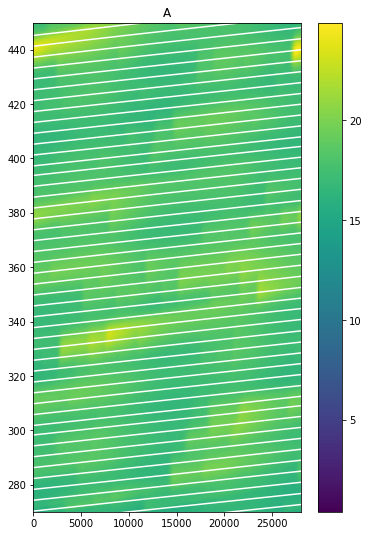

In [40]:
plt.figure(figsize=(6.,9))
plt.pcolormesh(x/1e3,t[:]/86400,(Ahat+model.A0[np.newaxis,:])[:],shading='Gouraud',cmap='viridis')
plt.ylim(150,450)
plt.colorbar()
traj = np.zeros((40,x.shape[0]))
t0s = np.linspace(250*86400.0,445*86400.0,num=50)
for nt in range(0,50):
    tps,xps = trajectory_ua(t0s[nt],x,t,ua,28000.0e3)
    plt.plot(xps/1e3,tps/86400,color='w')
plt.title("A")
plt.ylim(270,450)
plt.xlim(0,28000)
#plt.savefig("lwa_flux_random-cx-s.pdf",bbox_inches='tight')

(0, 28000)

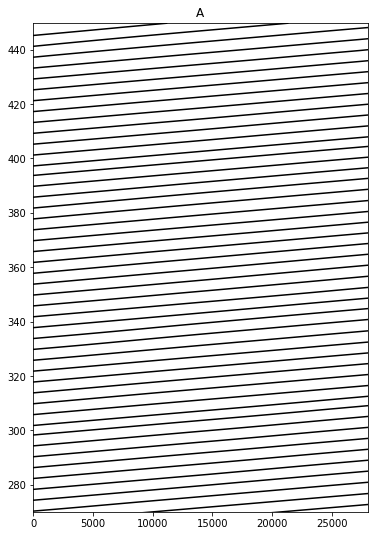

In [41]:
plt.figure(figsize=(6.,9))
#plt.pcolormesh(x/1e3,t[:]/86400,(Ahat+model.A0[np.newaxis,:])[:],shading='Gouraud',cmap='viridis')
#plt.ylim(150,450)
#plt.colorbar()
traj = np.zeros((40,x.shape[0]))
t0s = np.linspace(250*86400.0,445*86400.0,num=50)
for nt in range(0,50):
    tps,xps = trajectory_ua(t0s[nt],x,t,ua,28000.0e3)
    plt.plot(xps/1e3,tps/86400,color='k')
plt.title("A")
plt.ylim(270,450)
plt.xlim(0,28000)
#plt.savefig("lwa_flux_random-cx-s.pdf",bbox_inches='tight')

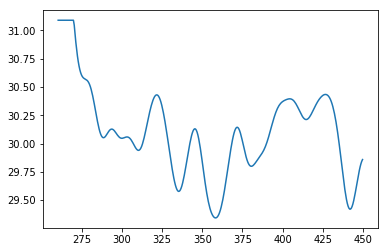

In [42]:
plt.plot(t[it0:]/86400,np.mean(ua[it0:],axis=1))

In [78]:
gamma = 4*cond.alpha*F/C**2

The flux saturation $\Gamma(x,t)$ is defined as $$\Gamma(x,t) = \frac{4\alpha F(x,t)}{C^2(x)}.$$

0.9999999999899026


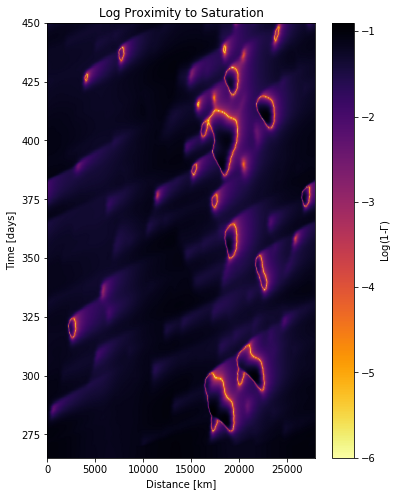

In [79]:
plt.figure(figsize=(6.,8))
im=plt.pcolormesh(x/1e3,t[it0:]/86400,np.log10(np.maximum(1.0-(gamma)[it0:],1.0e-6)),shading='Gouraud',cmap='inferno_r')
plt.colorbar(im,label="Log(1-$\Gamma$)")
#plt.contour(x/1e3,t[it0:]/86400,(gamma)[it0:],0.99999,colors='g')
plt.ylim(265,450)
plt.title("Log Proximity to Saturation")
plt.ylabel("Time [days]")
plt.xlabel("Distance [km]")
print(gamma.max())
#plt.savefig("gamma.png",bbox_inches='tight')

In [45]:
masked = gamma.copy()
masked[np.where(gamma<0.99999)]=0
masked[np.where(gamma>=0.99999)]=1

Text(0.5,1,'Flux Saturated Yes/No')

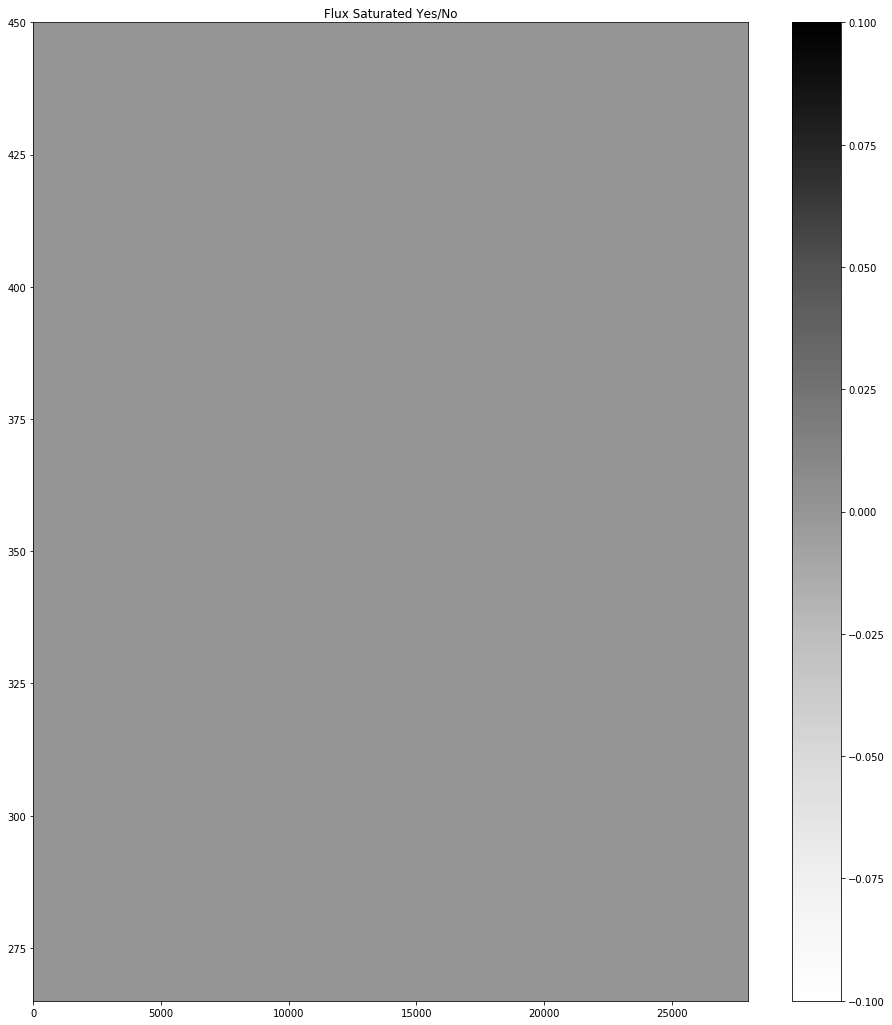

In [46]:

plt.figure(figsize=(16.,18))
plt.pcolormesh(x/1e3,t[it0:]/86400,(masked)[it0:],cmap='Greys')
plt.colorbar()
plt.ylim(265,450)
plt.title("Flux Saturated Yes/No")

Text(0.5,1,'$|\\partial_t A|$')

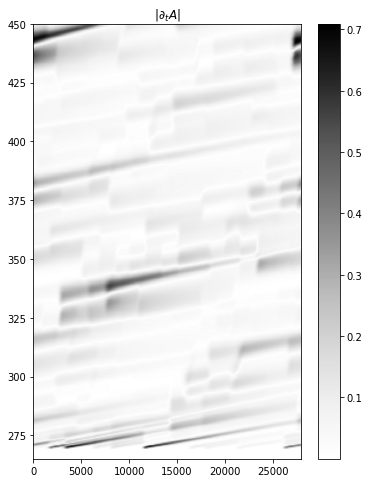

In [47]:
plt.figure(figsize=(6.,8))
plt.pcolormesh(x/1e3,t[it0:]/86400,abs(np.gradient((Ahat+model.A0[np.newaxis,:])[it0:],axis=0)),shading='Gouraud',cmap='Greys')
plt.colorbar()
plt.ylim(265,450)
plt.title("$|\partial_t A|$")

Text(0.5,1,'$|\\partial_x F|$')

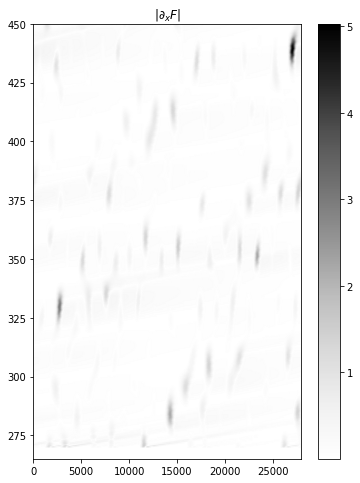

In [48]:
plt.figure(figsize=(6.,8))
plt.pcolormesh(x/1e3,t[it0:]/86400,abs(np.gradient(F[it0:],axis=1)),shading='Gouraud',cmap='Greys')
plt.colorbar()
plt.ylim(265,450)
plt.title("$|\partial_x F|$")

Text(0.5,1,'$|\\partial_x u|$')

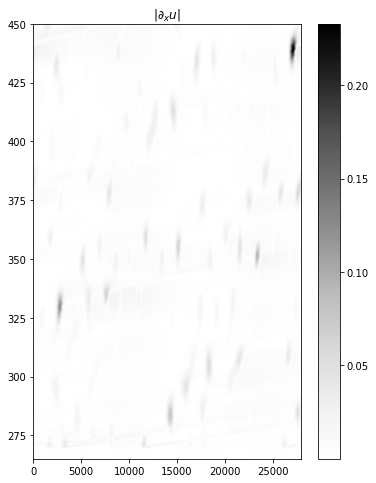

In [49]:
plt.figure(figsize=(6.,8))
plt.pcolormesh(x/1e3,t[it0:]/86400,abs(np.gradient(ua[it0:],axis=1)),shading='Gouraud',cmap='Greys')
plt.colorbar()
plt.ylim(265,450)
plt.title("$|\partial_x u|$")

In [50]:
print(np.mean((np.gradient(F[it0:],axis=1))),np.std((np.gradient(F[it0:],axis=1))))

2.1267452057654719e-07 0.21199735135223607


Text(0.5,1,'$\\left(\\partial_x F - <\\partial_x F>\\right)/\\sigma_{\\partial_x F}$')

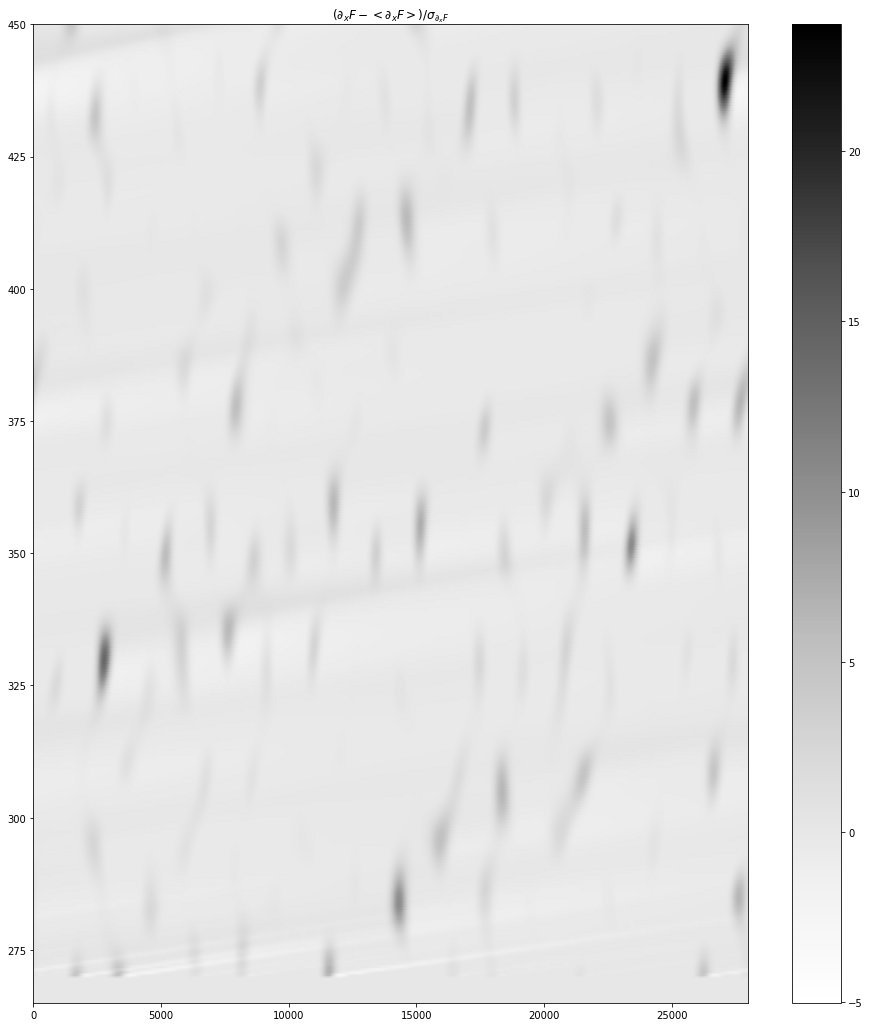

In [51]:
plt.figure(figsize=(16.,18))
grad = (np.gradient(F[it0:],axis=1))
plt.pcolormesh(x/1e3,t[it0:]/86400,((grad-np.mean(grad))/np.std(grad)),shading='Gouraud',cmap='Greys')
plt.colorbar()
plt.ylim(265,450)
#plt.xlim(14000,24000)
plt.title("$\left(\partial_x F - <\partial_x F>\\right)/\sigma_{\partial_x F}$")

Text(0.5,1,'$\\left(<\\partial_x u> - \\partial_xu\\right)/\\sigma_{\\partial_x u}$')

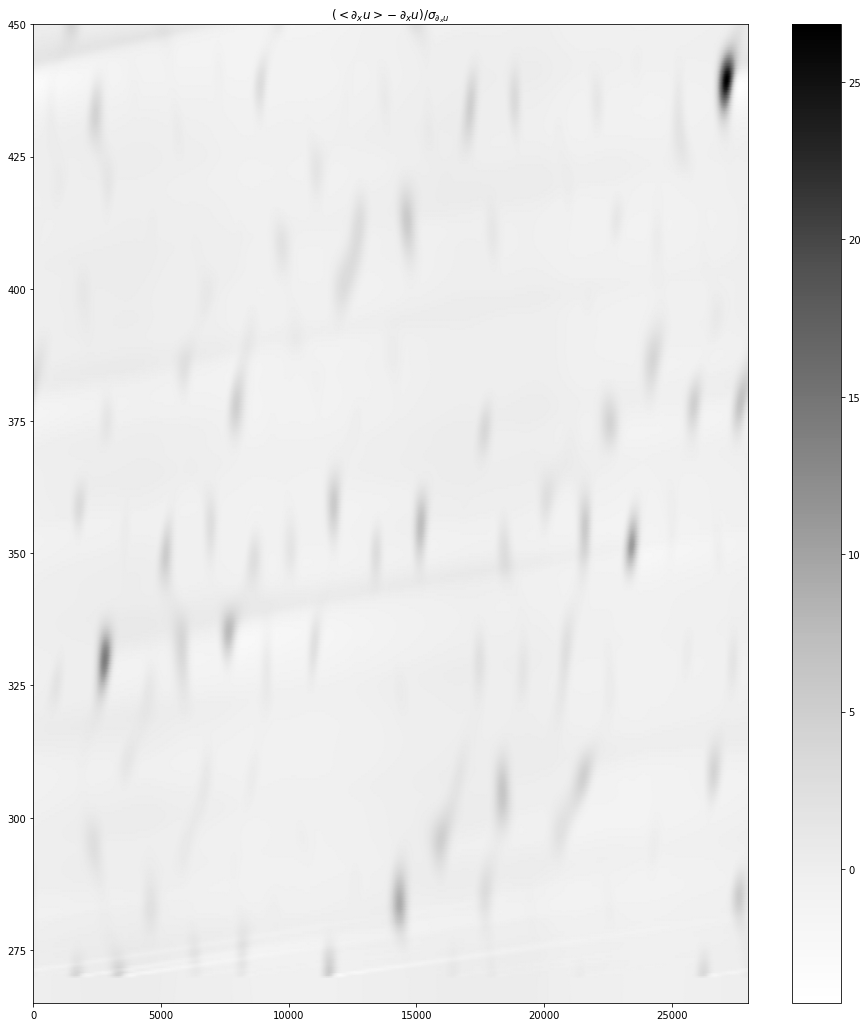

In [52]:
plt.figure(figsize=(16.,18))
ugrad = -(np.gradient(ua[it0:],axis=1))
plt.pcolormesh(x/1e3,t[it0:]/86400,((ugrad-np.mean(ugrad))/np.std(ugrad)),shading='Gouraud',cmap='Greys')
plt.colorbar()
plt.ylim(265,450)
#plt.xlim(14000,24000)
plt.title("$\left(<\partial_x u> - \partial_xu\\right)/\sigma_{\partial_x u}$")

Text(0.5,1,'$\\left(\\partial_x F - <\\partial_x F>\\right)/\\sigma_{\\partial_x F}$ > 10 Binary Flag')

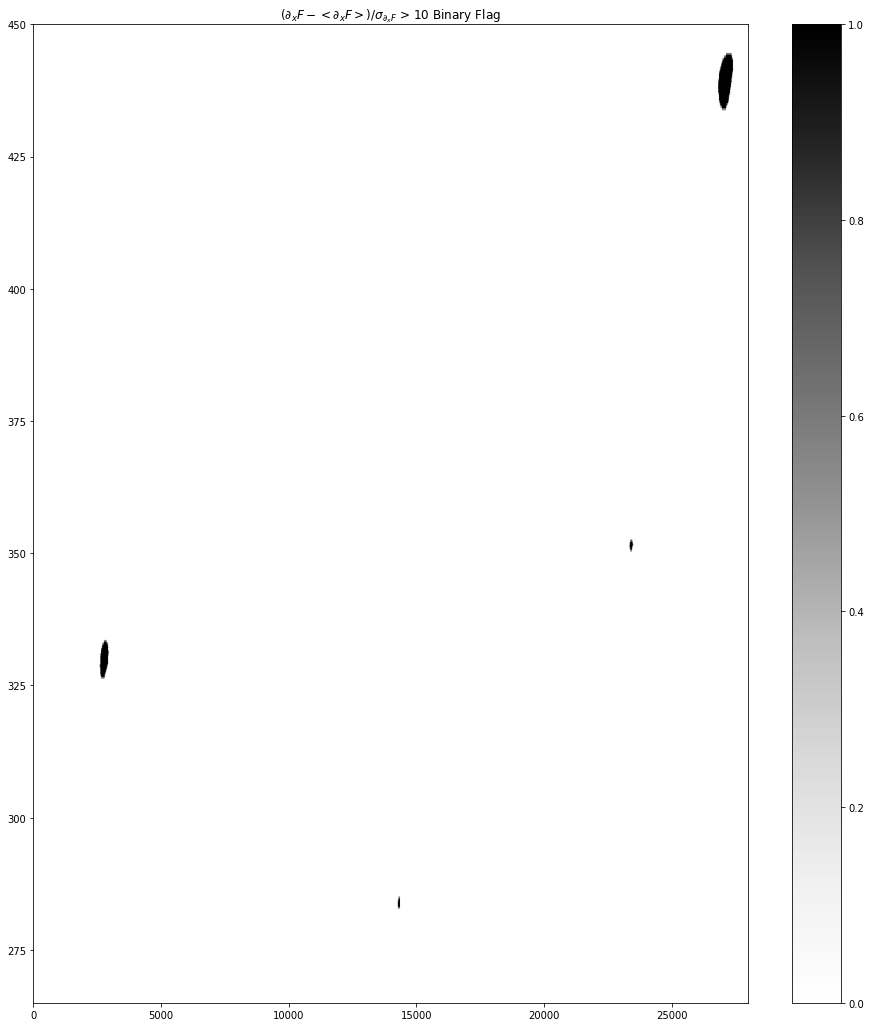

In [53]:
plt.figure(figsize=(16.,18))
thresh = 10
grad = (np.gradient(F[it0:],axis=1))
plt.pcolormesh(x/1e3,t[it0:]/86400,((grad-np.mean(grad))/np.std(grad) > thresh)*1.0,shading='Gouraud',cmap='Greys')
plt.colorbar()
plt.ylim(265,450)
#plt.xlim(14000,24000)
plt.title("$\left(\partial_x F - <\partial_x F>\\right)/\sigma_{\partial_x F}$ > %d Binary Flag"%thresh)

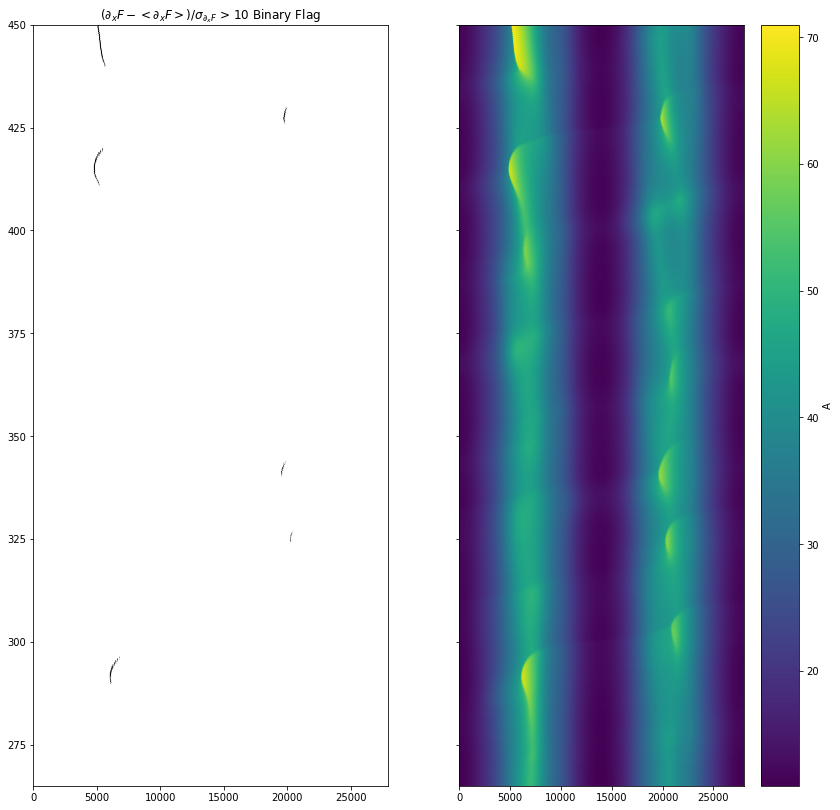

In [55]:
fix,axes=plt.subplots(1,2,figsize=(14,14),sharey=True)

im1=axes[0].pcolormesh(x/1e3,t[it0:]/86400,((grad-np.mean(grad))/np.std(grad) > thresh)*1.0,shading='Gouraud',cmap='Greys')
axes[0].set_ylim(265,450)
axes[0].set_title("$\left(\partial_x F - <\partial_x F>\\right)/\sigma_{\partial_x F}$ > %d Binary Flag"%thresh)
im2 = axes[1].pcolormesh(x/1e3,t[it0:]/86400,(Ahat+model.A0[np.newaxis,:])[it0:],shading='Gouraud',cmap='viridis')
axes[1].set_ylim(265,450)
plt.colorbar(im2,ax=axes[1],label="A")

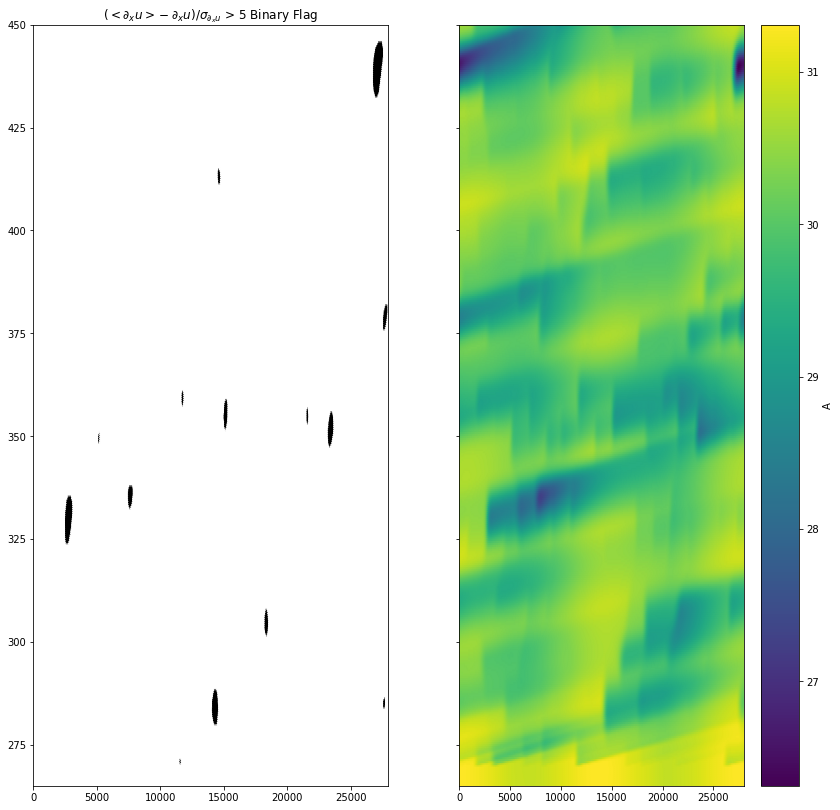

In [54]:
fix,axes=plt.subplots(1,2,figsize=(14,14),sharey=True)
threshu = 5
im1=axes[0].pcolormesh(x/1e3,t[it0:]/86400,((ugrad-np.mean(ugrad))/np.std(ugrad) > threshu)*1.0,shading='Gouraud',cmap='Greys')
axes[0].set_ylim(265,450)
axes[0].set_title("$\left(<\partial_x u> - \partial_xu\\right)/\sigma_{\partial_x u}$ > %d Binary Flag"%threshu)
im2 = axes[1].pcolormesh(x/1e3,t[it0:]/86400,ua[it0:],shading='Gouraud',cmap='viridis')
axes[1].set_ylim(265,450)
plt.colorbar(im2,ax=axes[1],label="A")

In [57]:
fmask = ((grad-np.mean(grad))/np.std(grad) > thresh)*1.0

In [58]:
ict,dmask = count_blocks(fmask,80,10)

In [59]:
print(ict)

6.0


In [ ]:
umask = ((ugrad - np.mean(ugrad))/np.std(ugrad) > threshu)*1.0
uct,umask = count_blocks(umask,80,10)
print(uct)
uts = t[it0:][np.where(umask>0.5)[0]]/86400
uxs = x[np.where(umask>0.5)[1]]/1e3

In [61]:

ts = t[it0:][np.where(dmask>0.5)[0]]/86400
xs = x[np.where(dmask>0.5)[1]]/1e3
print(ts,xs)

[290.25 324.75 340.75 411.25 426.25 440.25] [ 6152.34375 20289.0625  19605.46875  5222.65625 19851.5625   5687.5    ]


/home/adiv/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Text(0.5,1,'$\\left(\\partial_x F - <\\partial_x F>\\right)/\\sigma_{\\partial_x F}$ > 10 Binary Flag')

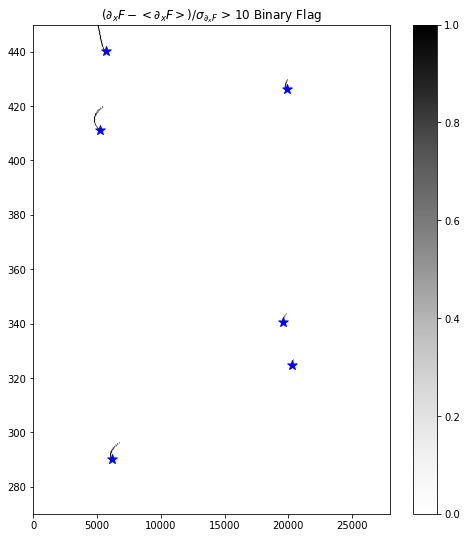

In [62]:
plt.figure(figsize=(8.,9))
grad = (np.gradient(F[it0:],axis=1))
blank = np.zeros(masked.shape)
blank[it0+250:it0+260,1300:1380] = 1.0
plt.pcolormesh(x/1e3,t[it0:]/86400,((grad-np.mean(grad))/np.std(grad) > thresh)*1.0,shading='Gouraud',cmap='Greys')
plt.colorbar()
plt.contour(x/1e3,t[it0:]/86400,blank[it0:],(0.5,),colors='r')
plt.scatter(xs,ts,s=100,marker='*',color='b')
plt.ylim(270,450)
#plt.xlim(14000,24000)
plt.title("$\left(\partial_x F - <\partial_x F>\\right)/\sigma_{\partial_x F}$ > %d Binary Flag"%thresh)

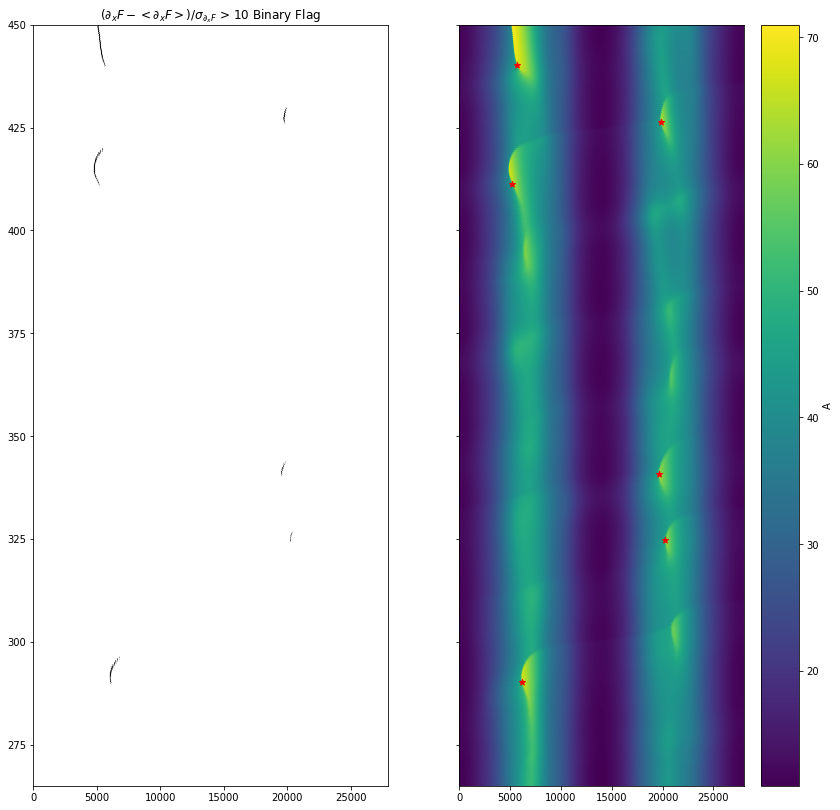

In [63]:
fix,axes=plt.subplots(1,2,figsize=(14,14),sharey=True)

im1=axes[0].pcolormesh(x/1e3,t[it0:]/86400,((grad-np.mean(grad))/np.std(grad) > thresh)*1.0,shading='Gouraud',cmap='Greys')
axes[0].set_ylim(265,450)
axes[0].set_title("$\left(\partial_x F - <\partial_x F>\\right)/\sigma_{\partial_x F}$ > %d Binary Flag"%thresh)
im2 = axes[1].pcolormesh(x/1e3,t[it0:]/86400,(Ahat+model.A0[np.newaxis,:])[it0:],shading='Gouraud',cmap='viridis')
axes[1].scatter(xs,ts,s=40,marker='*',color='r')
axes[1].set_ylim(265,450)
plt.colorbar(im2,ax=axes[1],label="A")

NameError: name 'uxs' is not defined

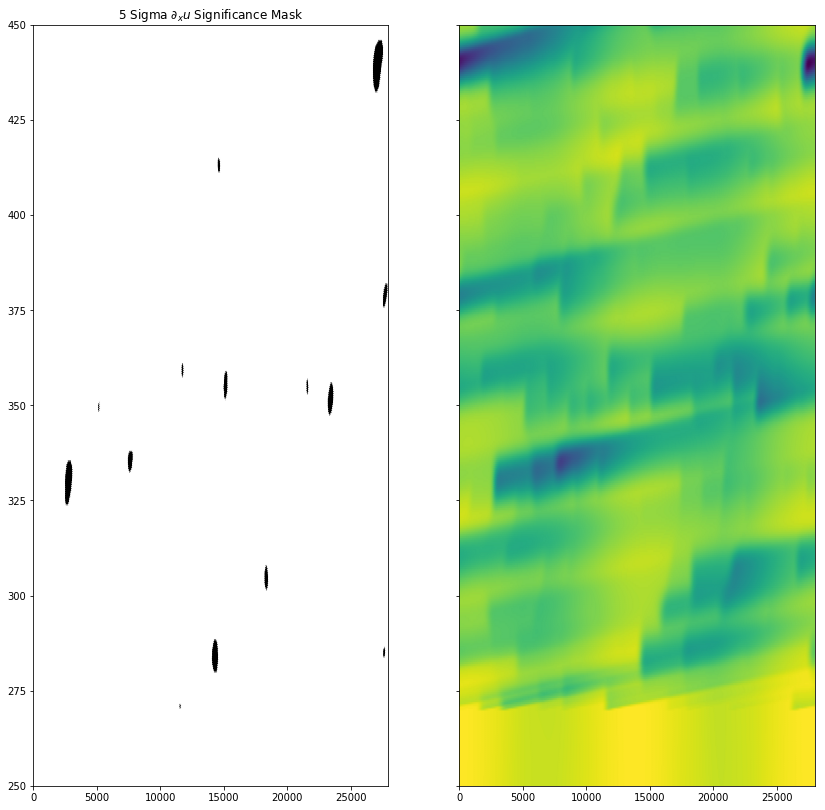

In [81]:
fix,axes=plt.subplots(1,2,figsize=(14,14),sharey=True)

im1=axes[0].pcolormesh(x/1e3,t[it0:]/86400,((ugrad-np.mean(ugrad))/np.std(ugrad) > threshu)*1.0,shading='Gouraud',cmap='Greys')
axes[0].set_ylim(250,450)
axes[0].set_title("%d Sigma $\partial_x u$ Significance Mask"%threshu)
im2 = axes[1].pcolormesh(x/1e3,t[it0-50:]/86400,ua[it0-50:],shading='Gouraud',cmap='viridis')
axes[0].scatter(uxs,uts,s=40,marker='*',color='b')
axes[1].scatter(uxs,uts,s=40,marker='*',color='r')
axes[1].set_ylim(250,450)
axes[0].set_ylabel("Time [days]")
axes[0].set_xlabel("Distance [km]")
axes[1].set_xlabel("Distance [km]")
axes[1].set_title("Eastward Wind")
plt.colorbar(im2,ax=axes[1],label="u [m/s]")
#plt.savefig("blockidentification.png",bbox_inches='tight')

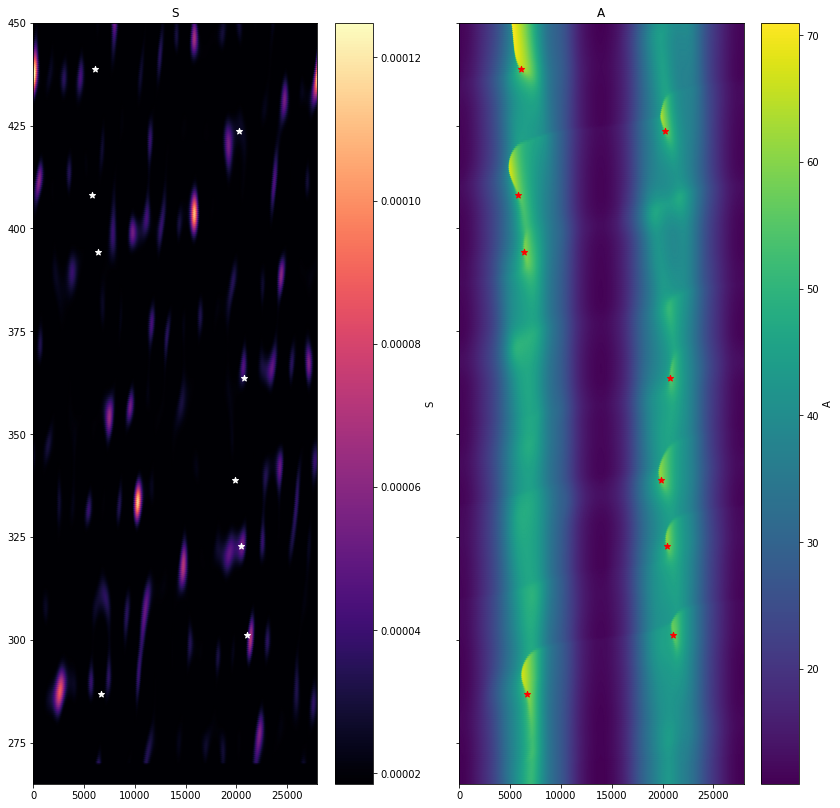

In [65]:
fix,axes=plt.subplots(1,2,figsize=(14,14),sharey=True)

im1=axes[0].pcolormesh(x/1e3,t[it0:]/86400,S[it0:],shading='Gouraud',cmap='magma')
axes[0].scatter(uxs,uts,s=40,marker='*',color='w')
axes[0].set_ylim(265,450)
axes[0].set_title("S")
#plt.legend(loc='best')
im2 = axes[1].pcolormesh(x/1e3,t[it0:]/86400,(Ahat+model.A0[np.newaxis,:])[it0:],shading='Gouraud',cmap='viridis')
axes[1].scatter(uxs,uts,s=40,marker='*',color='r')
axes[1].set_ylim(265,450)
axes[1].set_title("A")
plt.colorbar(im1,ax=axes[0],label="S")
plt.colorbar(im2,ax=axes[1],label="A")

In [66]:
S.shape

(900, 1024)

In [67]:
itu = np.where(t>=uts[3]*86400.0)[0][0]
print(S[itu-50:itu+50,:].shape)

(100, 1024)


In [68]:
sstack = np.zeros((100,1024))
astack = np.zeros((100,1024))
fstack = np.zeros((100,1024))
gstack = np.zeros((100,1024))
mfactor = np.zeros((100,1024))

for ut in uts:
    itu = np.where(t>=ut*86400.0)[0][0]
    sslice = S[itu:itu+100,:]
    spiece = np.zeros((100,1024))
    spiece[0:sslice.shape[0],:] = sslice[:]
    mfactor[0:sslice.shape[0],:] += 1.0
    sstack += spiece
    aslice = (Ahat+model.A0[np.newaxis,:])[itu-50:itu+50,:]
    apiece = np.zeros((100,1024))
    apiece[0:aslice.shape[0],:] = aslice[:]
    astack += apiece
    fslice = F[itu-50:itu+50,:]
    fpiece = np.zeros((100,1024))
    fpiece[0:fslice.shape[0],:] = fslice[:]
    fstack += fpiece
    gslice = gamma[itu-50:itu+50,:]
    gpiece = np.zeros((100,1024))
    gpiece[0:gslice.shape[0],:] = gslice[:]
    gstack += gpiece
    
sstack /= mfactor
astack /= mfactor
fstack /= mfactor
gstack /= mfactor


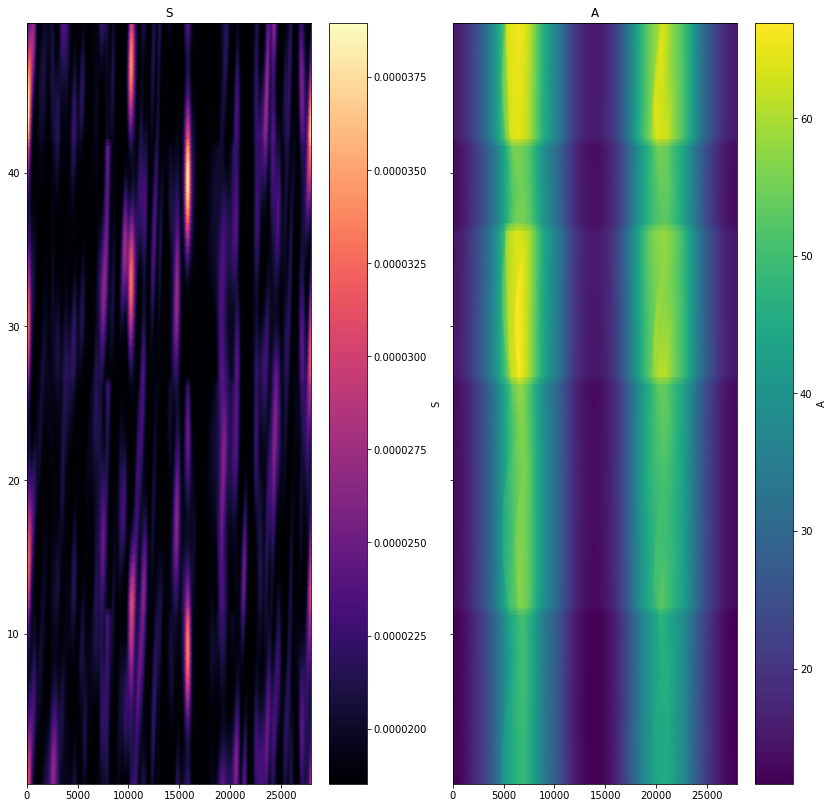

In [69]:
fix,axes=plt.subplots(1,2,figsize=(14,14),sharey=True)

im1=axes[0].pcolormesh(x/1e3,t[0:100]/86400,sstack,shading='Gouraud',cmap='magma')
axes[0].set_title("S")
#plt.legend(loc='best')
im2 = axes[1].pcolormesh(x/1e3,t[0:100]/86400,astack,shading='Gouraud',cmap='viridis')
axes[1].set_title("A")
plt.colorbar(im1,ax=axes[0],label="S")
plt.colorbar(im2,ax=axes[1],label="A")

/home/adiv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


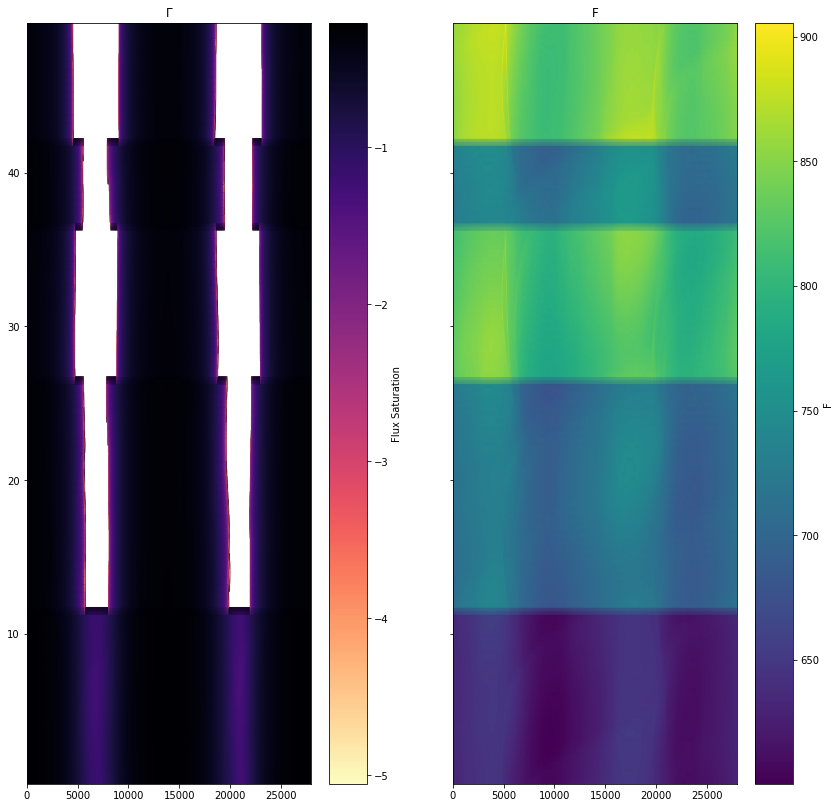

In [70]:
fix,axes=plt.subplots(1,2,figsize=(14,14),sharey=True)

im1=axes[0].pcolormesh(x/1e3,t[0:100]/86400,np.log10(1-gstack),shading='Gouraud',cmap='magma_r')
axes[0].set_title("$\Gamma$")
#plt.legend(loc='best')
im2 = axes[1].pcolormesh(x/1e3,t[0:100]/86400,fstack,shading='Gouraud',cmap='viridis')
axes[1].set_title("F")
plt.colorbar(im1,ax=axes[0],label="Flux Saturation")
plt.colorbar(im2,ax=axes[1],label="F")

/home/adiv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


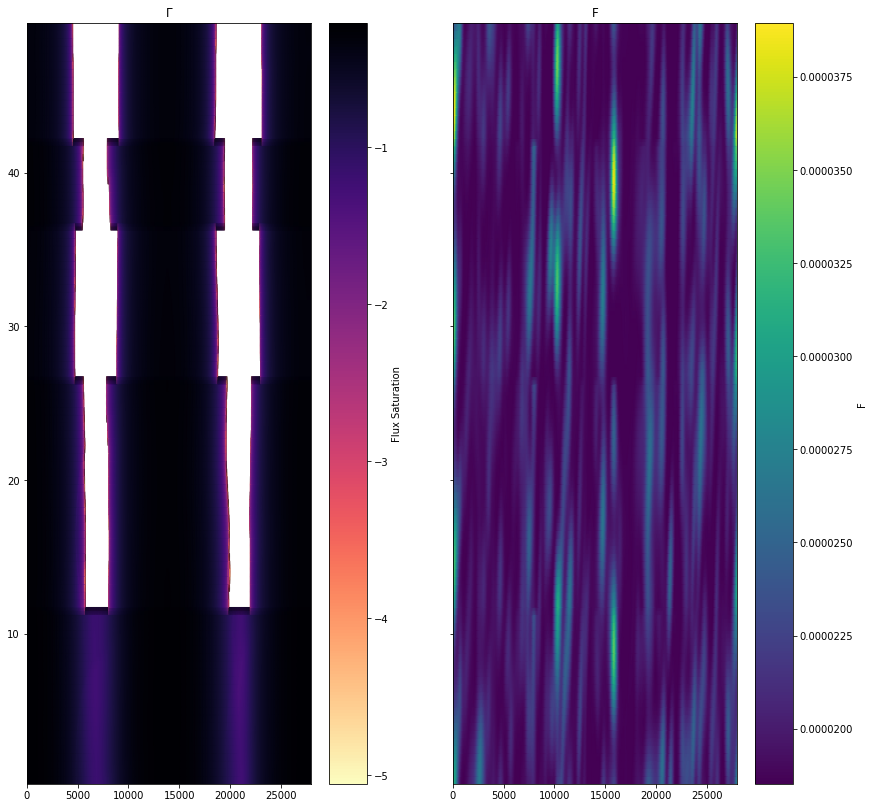

In [71]:
fix,axes=plt.subplots(1,2,figsize=(14,14),sharey=True)

im1=axes[0].pcolormesh(x/1e3,t[0:100]/86400,np.log10(1-gstack),shading='Gouraud',cmap='magma_r')
axes[0].set_title("$\Gamma$")
#plt.legend(loc='best')
im2 = axes[1].pcolormesh(x/1e3,t[0:100]/86400,sstack,shading='Gouraud',cmap='viridis')
axes[1].set_title("F")
plt.colorbar(im1,ax=axes[0],label="Flux Saturation")
plt.colorbar(im2,ax=axes[1],label="F")

/home/adiv/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'shading'
  s)


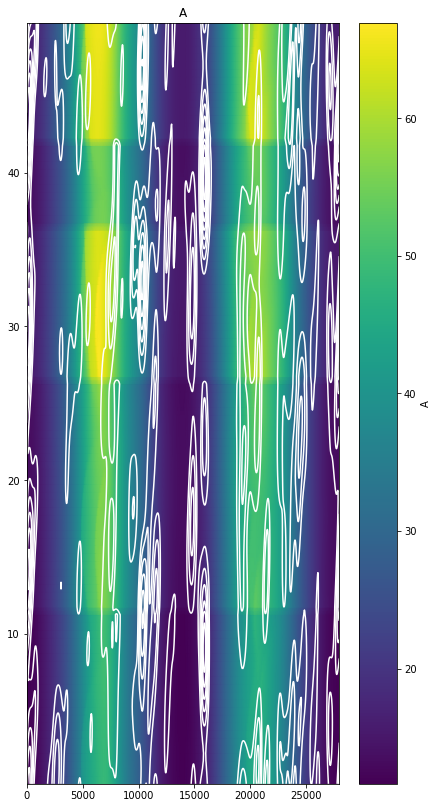

In [72]:
fix,axes=plt.subplots(figsize=(7,14),sharey=True)

#plt.legend(loc='best')
im2 = axes.pcolormesh(x/1e3,t[0:100]/86400,astack,shading='Gouraud',cmap='viridis')
im1=axes.contour(x/1e3,t[0:100]/86400,sstack,np.linspace(np.amin(sstack),np.amax(sstack),num=10),colors='w',shading='Gouraud')
axes.set_title("A")
plt.colorbar(im2,ax=axes,label="A")

In [74]:
noisy_initc = noisyconditions(nwcx=21,maxA0x=10,A0decay=40,cfunc=noisybackground,background=True,forcing=True,n=2,Y=4,beta=35)

### Note: Following cell deletes output folder. May want to turn off.

In [75]:
cleanup = True
if cleanup:
    os.system("rm -rf output/")

In [76]:
cond = noisy_initc

In [77]:
model = AtmosphericBlocking.Model(nx=1024,Lx = 28000e3,dt=.005*86400,alpha=cond.alpha,
                                        tmax=3.5*86400,D=3.26e5,tau=cond.tau,
                                        sfunc=cond.forcing,cfunc=cond.getcx,
                                        forcingpeak=cond.peak,injection=cond.inject,
                                        save_to_disk=True,
                                        overwrite=True,
                                        tsave_snapshots=50,
                                        path = 'output/')

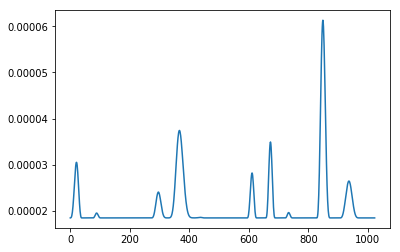

In [78]:
plt.plot(model.sfunc(model.x,280.0*86400.0))

In [79]:
model.tmax = 450*86400
model.run()

In [80]:

setup = h5py.File("output/setup.h5")
x = setup['grid/x'][:]

In [81]:
fnis = np.array(sorted(glob.glob("output/snapshots/*.h5")))

In [82]:
Ahat, F, S, C = 0,0,0,0
t = []
for fni in fnis[0::2]:
    snap = h5py.File(fni)
    t.append(snap['t'][()])
    try:
        Ahat = np.vstack([Ahat, snap['A'][:]])
        F = np.vstack([F, snap['F'][:]])
        S = np.vstack([S, snap['S'][:]])
        C = np.vstack([C, snap['C'][:]])
    except:
        Ahat = snap['A'][:]
        F = snap['F'][:]
        S = snap['S'][:]
        C = snap['C'][:]

t = np.array(t)

In [83]:
fnis.shape

(1800,)

In [84]:
t.shape

(900,)

In [85]:
print(Ahat.shape,model.A0.shape,F.shape)

(900, 1024) (1024,) (900, 1024)


In [86]:
print(np.where(t/86400 > 260)[0][0])
it0 = np.where(t/86400 > 260)[0][0]

520


Text(0.5,1,'S')

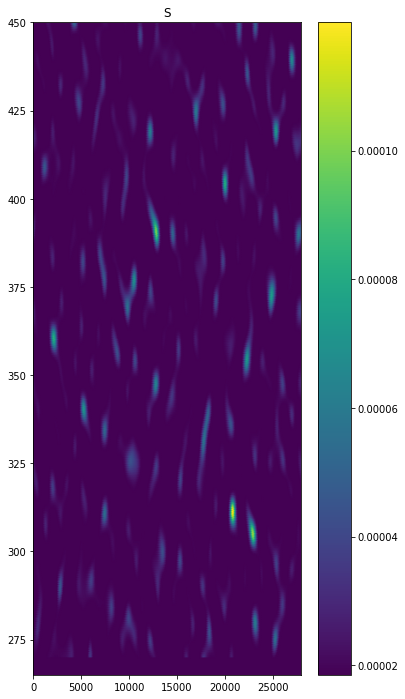

In [87]:
fig,ax=plt.subplots(figsize=(6.,12.))
plt.pcolormesh(x/1e3,t[it0:]/86400,(S[it0:]),shading='Gouraud',cmap='viridis')
plt.ylim(265,450)
plt.colorbar()
plt.title("S")
#plt.savefig("s_field.pdf",bbox_inches='tight')

15.0


Text(0.5,1,'S Mask')

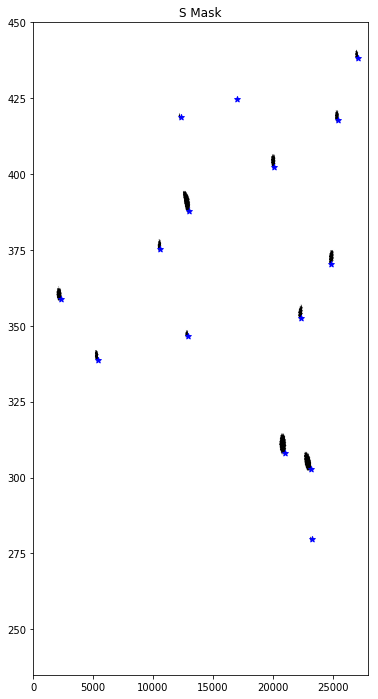

In [88]:
smask = (S[it0-100:]>0.6e-4)*1.0

sct,scmask = count_blocks(smask,5,5)
print(sct)
sts = t[it0-100:][np.where(scmask>0.5)[0]]/86400
sxs = x[np.where(scmask>0.5)[1]]/1e3
fig,ax=plt.subplots(figsize=(6.,12.))
plt.pcolormesh(x/1e3,t[it0-100:]/86400,smask,shading='Gouraud',cmap='Greys')
plt.scatter(sxs,sts,marker='*',color='b')
plt.ylim(235,450)
plt.title("S Mask")

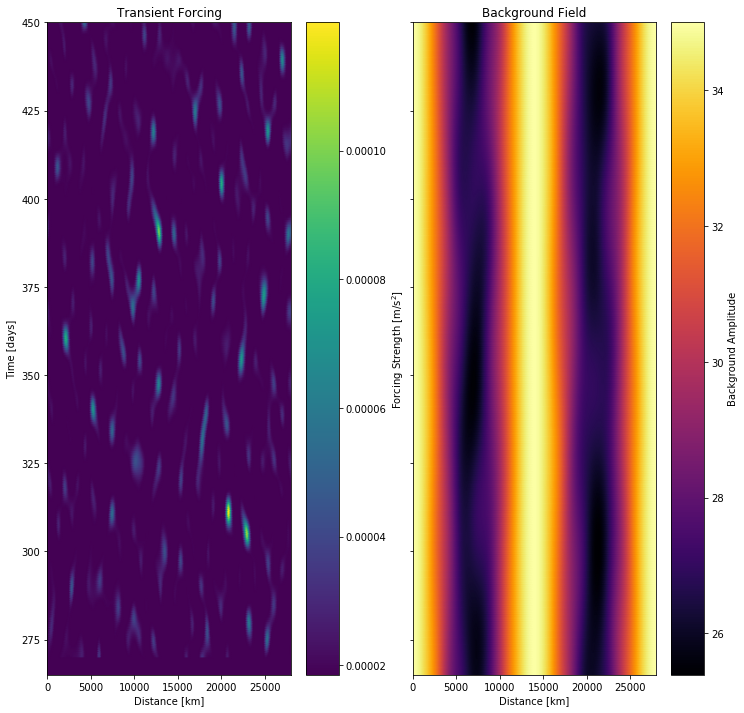

In [89]:
fig,axes=plt.subplots(1,2,figsize=(12.,12.),sharey=True)
im1=axes[0].pcolormesh(x/1e3,t[it0:]/86400,(S[it0:]),shading='Gouraud',cmap='viridis')
axes[0].set_ylim(265,450)
plt.colorbar(im1,label="Forcing Strength [m/s$^2$]",ax=axes[0])
axes[0].set_title("Transient Forcing")
im2=axes[1].pcolormesh(x/1e3,t[it0:]/86400,(C[it0:]),shading='Gouraud',cmap='inferno')
#plt.ylim(270,300)
#plt.xlim(7000,12000)
plt.colorbar(im2,label="Background Amplitude",ax=axes[1])
axes[1].set_title("Background Field")
axes[0].set_ylabel("Time [days]")
axes[0].set_xlabel("Distance [km]")
axes[1].set_xlabel("Distance [km]")
plt.savefig("qp_cx_s_field.png",bbox_inches='tight')

Text(0.5,1,'F')

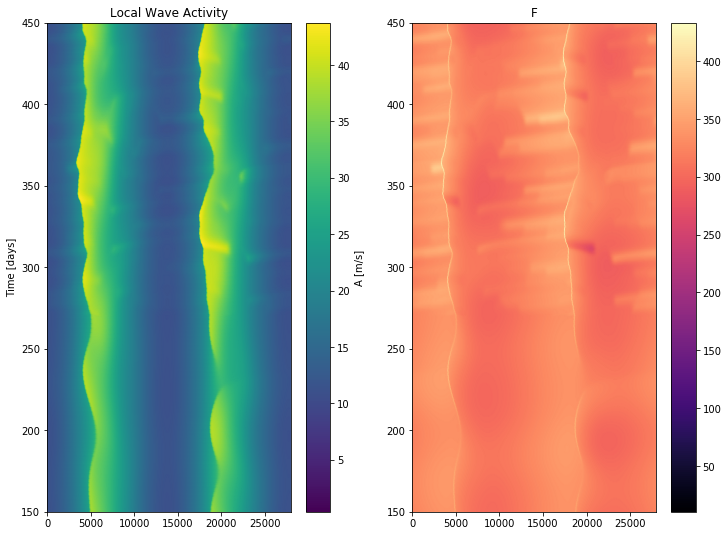

In [90]:
plt.figure(figsize=(12.,9))
plt.subplot(121)
plt.pcolormesh(x/1e3,t[:]/86400,(Ahat+model.A0[np.newaxis,:])[:],shading='Gouraud',cmap='viridis')
plt.ylim(150,450)
plt.ylabel("Time [days]")
plt.colorbar(label="A [m/s]")
plt.title("Local Wave Activity")

plt.subplot(122)
plt.pcolormesh(x/1e3,t[:]/86400,F[:],shading='Gouraud',cmap='magma')
plt.ylim(150,450)
plt.colorbar()
plt.title("F")
#plt.savefig("lwa_flux_random-cx-s.pdf",bbox_inches='tight')

In [91]:
import matplotlib.colors as colors

In [92]:
print(1)

1


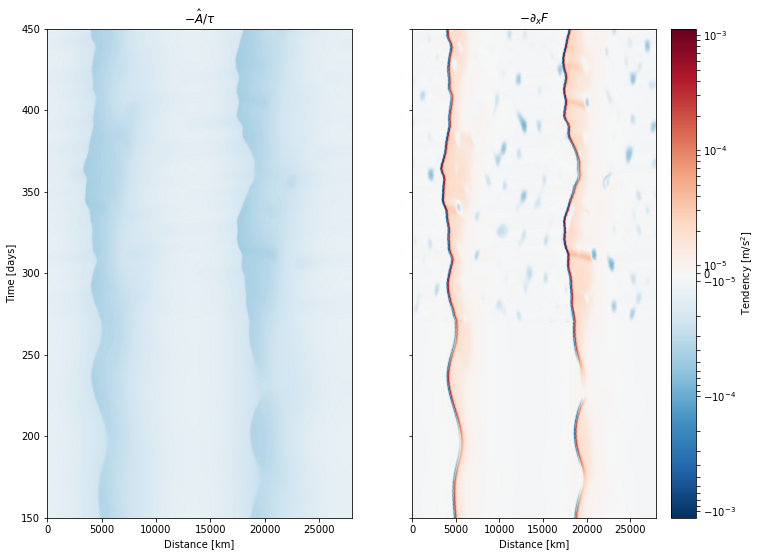

In [93]:

fterm = -np.gradient(F[:],x[1]-x[0],axis=1)
Dterm = 3.26e5*np.gradient(np.gradient(Ahat,x[1]-x[0],axis=1),x[1]-x[0],axis=1)
ahtau = -Ahat/(10.0*86400.0)
fmin = -np.amax(abs(fterm))
fmax = np.amax(abs(fterm))
ahmin = -np.amax(abs(ahtau))
ahmax = np.amax(abs(ahtau))
dmin = -np.amax(abs(Dterm))
dmax = np.amax(abs(Dterm))
smin = -np.amax(abs(S))
smax = np.amax(abs(S))
vmin = np.amin([fmin,ahmin,dmin,smin])
vmax = np.amax([fmax,ahmax,dmax,smax])

fig,axes=plt.subplots(1,2,figsize=(12.,9),sharey=True)
axes[0].pcolormesh(x/1e3,t[:]/86400,-(Ahat)/(10.0*86400.0),shading='Gouraud',cmap='RdBu_r',norm=colors.SymLogNorm(linthresh=1.0e-5, linscale=0.1,vmin=vmin,vmax=vmax))
axes[0].set_ylim(150,450)
axes[0].set_title("$-\hat{A}/\\tau$")
axes[0].set_ylabel("Time [days]")

im=axes[1].pcolormesh(x/1e3,t[:]/86400,fterm,shading='Gouraud',cmap='RdBu_r',norm=colors.SymLogNorm(linthresh=1.0e-5, linscale=0.1,vmin=vmin,vmax=vmax))
axes[1].set_ylim(150,450)
axes[1].set_xlabel("Distance [km]")
axes[0].set_xlabel("Distance [km]")
plt.colorbar(im,label="Tendency [m/s$^2$]",ax=axes[1])
axes[1].set_title("$-\partial_xF$")
plt.savefig("qp_eqn_components1.png",bbox_inches='tight')

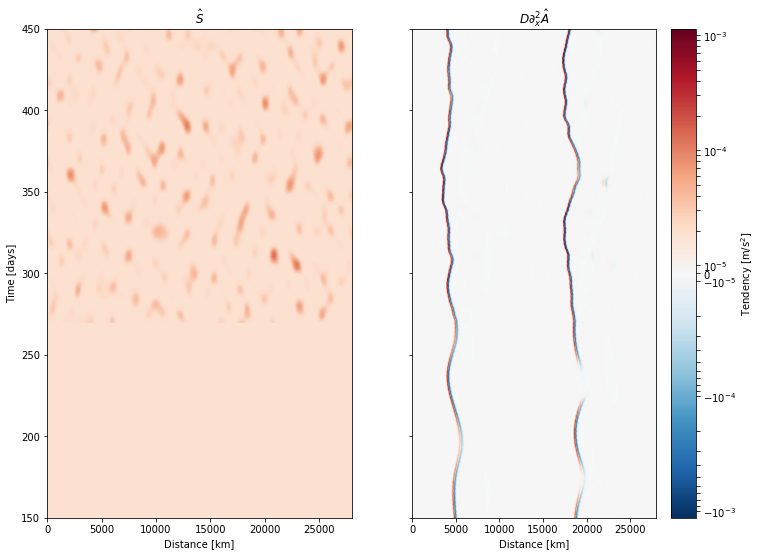

In [94]:
fig,axes = plt.subplots(1,2,figsize=(12.,9),sharey=True)
im=axes[0].pcolormesh(x/1e3,t[:]/86400,S,shading='Gouraud',cmap='RdBu_r',norm=colors.SymLogNorm(linthresh=1.0e-5, linscale=0.1,vmin=vmin,vmax=vmax))
axes[0].set_ylim(150,450)
axes[0].set_ylabel("Time [days]")
axes[0].set_title("$\hat{S}$")
axes[0].set_xlabel("Distance [km]")
axes[1].set_xlabel("Distance [km]")
axes[1].pcolormesh(x/1e3,t[:]/86400,Dterm,shading='Gouraud',cmap='RdBu_r',norm=colors.SymLogNorm(linthresh=1.0e-5, linscale=0.1,vmin=vmin,vmax=vmax))
axes[1].set_title("$D\partial_x^2\hat{A}$")
plt.colorbar(im,label="Tendency [m/s$^2$]",ax=axes[1])
plt.savefig("qp_eqn_components2.png",bbox_inches='tight')

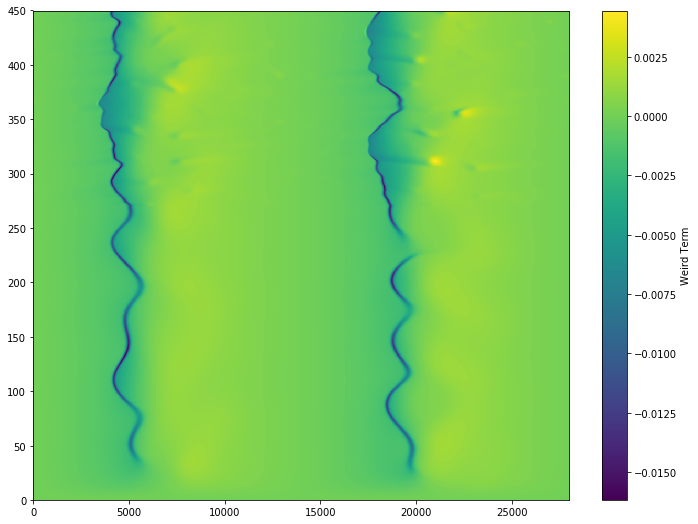

In [95]:
plt.figure(figsize=(12.,9))
im=plt.pcolormesh(x/1e3,t/86400,10*Ahat*np.gradient(np.cos(4*np.pi*model.x[np.newaxis]/28000.0e3)*Ahat,x[1]-x[0],axis=1))
plt.colorbar(im,label="Weird Term")

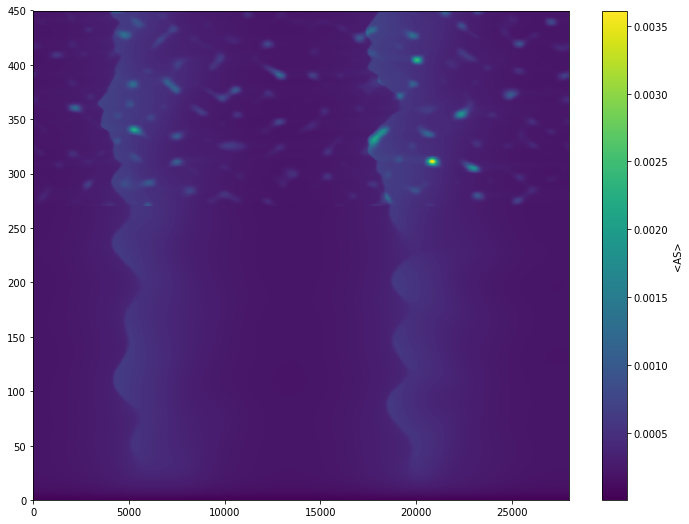

In [96]:
plt.figure(figsize=(12.,9))
im=plt.pcolormesh(x/1e3,t/86400,Ahat*S)
plt.colorbar(im,label="<AS>")

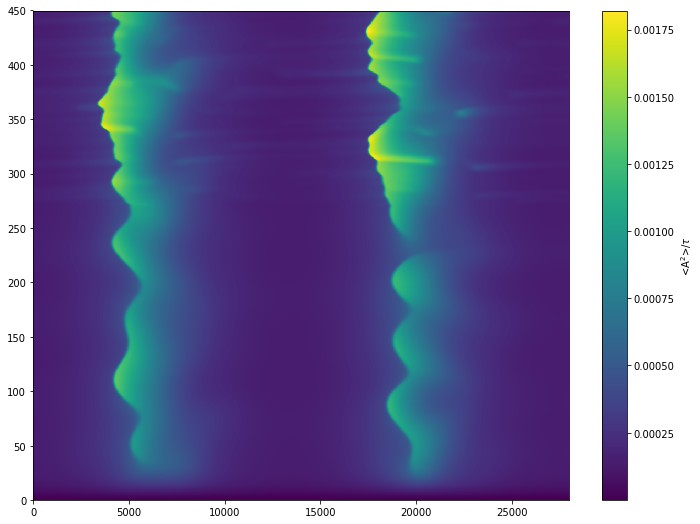

In [97]:
plt.figure(figsize=(12.,9))
im=plt.pcolormesh(x/1e3,t/86400,Ahat**2/(10.0*86400.0))
plt.colorbar(im,label="<A$^2$>/$\\tau$")

In [98]:
ua = 40-cond.alpha*(Ahat+model.A0[np.newaxis,:])

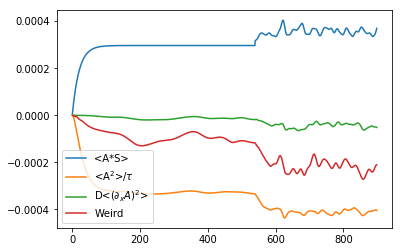

In [99]:
plt.plot(np.mean(Ahat*S,axis=1),label="<A*S>")
plt.plot(-np.mean(Ahat**2,axis=1)/(10.0*86400.0),label="<A$^2$>/$\\tau$")
plt.plot(-3.26e5*np.mean(np.gradient(Ahat,x[1]-x[0],axis=1)**2,axis=1),label="D<$(\partial_xA)^2$>")
plt.plot(np.mean(10*Ahat*np.gradient(np.cos(4*np.pi*model.x[np.newaxis]/28000.0e3)*Ahat,x[1]-x[0],axis=1),axis=1),label='Weird')
plt.legend(loc='best')
#plt.yscale('log')

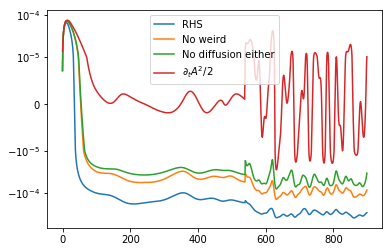

In [100]:
term1 = np.mean(Ahat*S,axis=1) \
      +np.mean(10*Ahat*np.gradient(np.cos(4*np.pi*model.x[np.newaxis]/28000.0e3)*Ahat,x[1]-x[0],axis=1),axis=1) \
      -np.mean(Ahat**2,axis=1)/(10.0*86400.0) \
      -3.26e5*np.mean(np.gradient(Ahat,x[1]-x[0],axis=1)**2,axis=1)
term2 = np.mean(Ahat*S,axis=1) \
      -np.mean(Ahat**2,axis=1)/(10.0*86400.0) \
      -3.26e5*np.mean(np.gradient(Ahat,x[1]-x[0],axis=1)**2,axis=1)
term3 = np.mean(Ahat*S,axis=1) \
      -np.mean(Ahat**2,axis=1)/(10.0*86400.0)
plt.plot(term1,label="RHS")
plt.plot(term2,label="No weird")
plt.plot(term3,label="No diffusion either")
plt.plot(np.gradient(np.mean(Ahat**2,axis=1),t[1]-t[0],axis=0)/2.0,label="$\partial_t A^2/2$")
plt.yscale('symlog',linthreshy=1.0e-5)
plt.legend(loc='best')

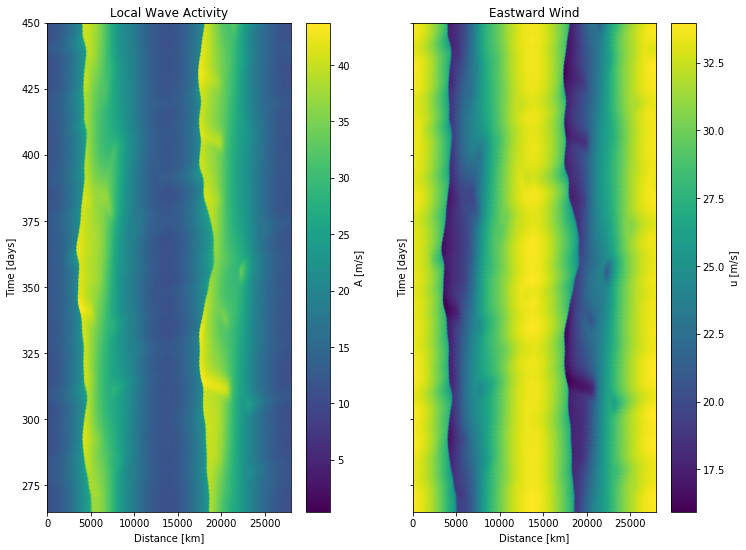

In [101]:
fig,axes=plt.subplots(1,2,figsize=(12.,9),sharey=True)
im=axes[0].pcolormesh(x/1e3,t[:]/86400,(Ahat+model.A0[np.newaxis,:])[:],shading='Gouraud',cmap='viridis')
axes[0].set_ylim(150,450)
axes[0].set_ylabel("Time [days]")
plt.colorbar(im,label="A [m/s]",ax=axes[0])
axes[0].set_title("Local Wave Activity")
axes[0].set_xlabel("Distance [km]")

im=axes[1].pcolormesh(x/1e3,t[it0:]/86400,(ua)[it0:],shading='Gouraud',cmap='viridis')
plt.colorbar(im,label="u [m/s]",ax=axes[1])
axes[1].set_ylim(265,450)
axes[1].set_ylabel("Time [days]")
axes[1].set_xlabel("Distance [km]")
axes[1].set_title("Eastward Wind")
plt.savefig("lwa_wind.png",bbox_inches='tight')

(0, 28000)

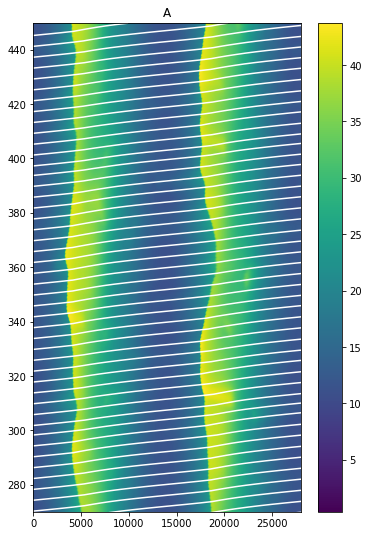

In [102]:
plt.figure(figsize=(6.,9))
plt.pcolormesh(x/1e3,t[:]/86400,(Ahat+model.A0[np.newaxis,:])[:],shading='Gouraud',cmap='viridis')
plt.ylim(150,450)
plt.colorbar()
traj = np.zeros((40,x.shape[0]))
t0s = np.linspace(250*86400.0,445*86400.0,num=50)
for nt in range(0,50):
    tps,xps = trajectory_ua(t0s[nt],x,t,ua,28000.0e3)
    plt.plot(xps/1e3,tps/86400,color='w')
plt.title("A")
plt.ylim(270,450)
plt.xlim(0,28000)
#plt.savefig("lwa_flux_random-cx-s.pdf",bbox_inches='tight')

(0, 28000)

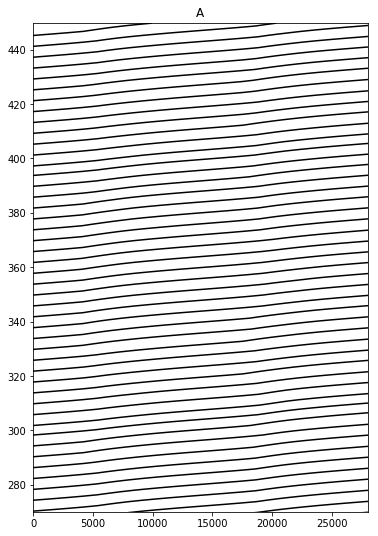

In [103]:
plt.figure(figsize=(6.,9))
#plt.pcolormesh(x/1e3,t[:]/86400,(Ahat+model.A0[np.newaxis,:])[:],shading='Gouraud',cmap='viridis')
#plt.ylim(150,450)
#plt.colorbar()
traj = np.zeros((40,x.shape[0]))
t0s = np.linspace(250*86400.0,445*86400.0,num=50)
for nt in range(0,50):
    tps,xps = trajectory_ua(t0s[nt],x,t,ua,28000.0e3)
    plt.plot(xps/1e3,tps/86400,color='k')
plt.title("A")
plt.ylim(270,450)
plt.xlim(0,28000)
#plt.savefig("lwa_flux_random-cx-s.pdf",bbox_inches='tight')

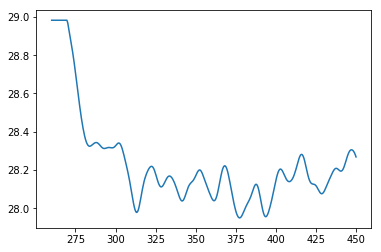

In [104]:
plt.plot(t[it0:]/86400,np.mean(ua[it0:],axis=1))

In [105]:
gamma = 4*cond.alpha*F/C**2

The flux saturation $\Gamma(x,t)$ is defined as $$\Gamma(x,t) = \frac{4\alpha F(x,t)}{C^2(x)}.$$

0.999999999999456


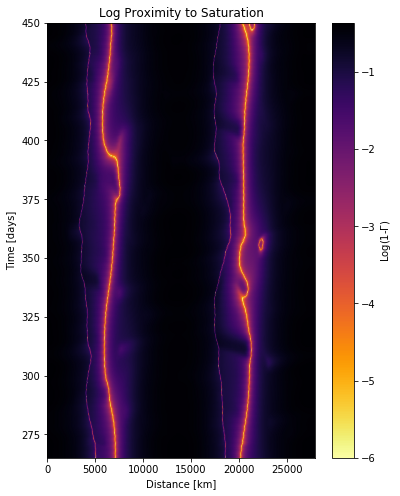

In [106]:
plt.figure(figsize=(6.,8))
im=plt.pcolormesh(x/1e3,t[it0:]/86400,np.log10(np.maximum(1.0-(gamma)[it0:],1.0e-6)),shading='Gouraud',cmap='inferno_r')
plt.colorbar(im,label="Log(1-$\Gamma$)")
#plt.contour(x/1e3,t[it0:]/86400,(gamma)[it0:],0.99999,colors='g')
plt.ylim(265,450)
plt.title("Log Proximity to Saturation")
plt.ylabel("Time [days]")
plt.xlabel("Distance [km]")
print(gamma.max())
plt.savefig("gamma_saturation.png",bbox_inches='tight')